# Further Experimentation - Hyperparameter Tuning

## Contents:<a class="anchor" id="contents"></a>
* [Setup, Data preparation and Callbacks](#setup)
* [Models with Growth Rate 16](#gr16)
* [Models with Growth Rate 6](#gr6)
* [Models with Growth Rate 10](#gr10)

## Setup, Data preparation and Callbacks <a class="anchor" id="setup"></a>
----------------------------------

In [1]:
%load_ext jupyternotify
import time
import tensorflow as tf
import keras.backend as K
import numpy as np
import pandas as pd
from sklearn.metrics import roc_curve
from keras import models, layers, optimizers, regularizers
from keras.models import Model
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing import image
from keras.utils import to_categorical
from keras import Input
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import keras
import os, shutil
from keras.utils import plot_model
from keras.callbacks import ModelCheckpoint, EarlyStopping

from keras_gcnn.layers import GConv2D, GBatchNorm
from keras_gcnn.layers.pooling import GroupPool

#Loading my custom functions from a separate Jupyter notebook
from ipynb.fs.full.my_functions import build_and_compile_model, build_and_compile_model_GCNN, fit_model_to_generator, plot_auc, area_under_ROC_curve
from ipynb.fs.full.my_functions import plot_results,plot_graphs, plot_smooth, plot_smooth_graphs, fit_model_to_directory_generator, evaluate_auc
from ipynb.fs.full.my_functions import build_and_compile_dense_model, crop, memory_required, count_conv_layers
from ipynb.fs.full.my_functions import model_ensemble_evaluation, acc_comparison, save_history, load_history

<IPython.core.display.Javascript object>

Using TensorFlow backend.


### Setting up custom Keras callbacks, mimicing the training setup of the academic papers.

In [2]:
class TimeSpent(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.epoch_times = []
    def on_epoch_begin(self, epoch,logs={}):
        self.time_started = time.time()
    def on_epoch_end(self, epoch,logs={}):
        self.epoch_times.append(time.time()-self.time_started)
        
class LR_modifier(keras.callbacks.Callback):
    def __init__(self,
                 monitor='val_loss',
                 patience=0,
                 verbose=0):
        super(LR_modifier, self).__init__()

        self.monitor = monitor
        self.monitor_op = np.less
        self.patience = patience
        self.verbose = verbose
        self.wait = 0

    def on_train_begin(self, logs=None):
        self.best = np.Inf

    def on_epoch_end(self, epoch, logs=None):
        current = self.get_monitor_value(logs)
        if current is None:
            return

        if self.monitor_op(current, self.best):
            self.best = current
            self.wait = 0
        else:
            self.wait += 1
            if self.wait >= self.patience:
                curr_lr = float(K.get_value(self.model.optimizer.lr))
                new_lr = curr_lr/2.
                K.set_value(self.model.optimizer.lr, new_lr)
                self.wait=0
                if(self.verbose==1):
                    print("Learn rate updated from {} to: {}".format(curr_lr,new_lr))

    def get_monitor_value(self, logs):
        monitor_value = logs.get(self.monitor)
        if monitor_value is None:
            warnings.warn(
                'Early stopping conditioned on metric `%s` '
                'which is not available. Available metrics are: %s' %
                (self.monitor, ','.join(list(logs.keys()))), RuntimeWarning
            )
        return monitor_value

    

time_check = TimeSpent()
lr_mod = LR_modifier(monitor="val_loss",patience=20,verbose=1)


totalepochs = 300
def sched(epoch,lr):
    if epoch == totalepochs*0.5 or epoch == totalepochs*0.75:
        return lr/10
    return lr

callbacks = [time_check,
            keras.callbacks.LearningRateScheduler(sched, verbose=1),
            keras.callbacks.ModelCheckpoint(
                filepath="../model_saves/PCAM/PCAM_Dense/weights.{epoch:02d}-{val_loss:.2f}.hdf5",
                monitor='val_loss',
                save_best_only=True),
#             keras.callbacks.EarlyStopping(
#             monitor='val_loss',
#             patience=100)
            ]

#### Rotational paper callbacks

In [3]:
callbacks = [time_check,
            keras.callbacks.ModelCheckpoint(
                filepath="../model_saves/PCAM/PCAM_Dense/weights.{epoch:02d}-{val_loss:.2f}.hdf5",
                monitor='val_loss',
                save_best_only=True),
             lr_mod
            ]

### Data preparation and generator setup

In [3]:
base_dir = "C:/GitRepos/FINAL PROJECT DATA/Histopathologic Cancer Detection/WholePCamSetFromGithub/converted_images/"
tr_dir = os.path.join(base_dir, "train")
va_dir = os.path.join(base_dir, "valid")
te_dir = os.path.join(base_dir, "test")

train_datagen = ImageDataGenerator(rescale=1./255)

batch_size = 64 
targ_size = (96,96)
classification = "binary"


validation_generator = train_datagen.flow_from_directory(
    va_dir,
    target_size=targ_size,
    batch_size=batch_size,
    class_mode=classification)

test_generator = train_datagen.flow_from_directory(
    te_dir,
    target_size=targ_size,
    batch_size=batch_size,
    class_mode=classification)

Found 32768 images belonging to 2 classes.
Found 32768 images belonging to 2 classes.


# Models with growth rate 16 <a class="anchor" id="gr16"></a>
----------------------------------

#### Model 1 - DenseSGD Training

In [10]:
initial_filters = 12
weight_decay = 1e-4 # Setting from the DenseNet paper
P4M_DenseNet_128 = build_and_compile_dense_model(initial_filters,growth_rate=16,dense_blocks=5,conv_layers=1,
                                           is_gconv=True,gconv_type="D4",padding="valid",dropout=0.2,img_size=96,
                                           opt="DenseSGD",weight_decay=weight_decay,output="sigmoid",labels=1,bc_model=False)

In [11]:
P4M_DenseNet_128.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 96, 96, 3)    0                                            
__________________________________________________________________________________________________
g_conv2d_21 (GConv2D)           (None, 94, 94, 96)   324         input_3[0][0]                    
__________________________________________________________________________________________________
g_batch_norm_21 (GBatchNorm)    (None, 94, 94, 96)   96          g_conv2d_21[0][0]                
__________________________________________________________________________________________________
activation_21 (Activation)      (None, 94, 94, 96)   0           g_batch_norm_21[0][0]            
__________________________________________________________________________________________________
g_conv2d_2

In [12]:
memory_required(P4M_DenseNet_128,64)

4.798

In [13]:
%%notify

totalepochs=300

historyP4M_DenseNet_128 = fit_model_to_directory_generator(P4M_DenseNet_128,train_datagen,tr_dir,validation_generator,
                                           callbacks=callbacks,steps=312,val_steps=len(validation_generator)-1,batch_size=64,epochs=totalepochs,verbose=1)
timeP4M_DenseNet_128 = np.sum(time_check.epoch_times)
P4M_DenseNet_128.save_weights("../model_saves/PCAM/PCam_Dense/P4M_DenseNet_128Final.h5")

Found 262144 images belonging to 2 classes.
Epoch 1/300

Epoch 00001: LearningRateScheduler setting learning rate to 0.10000000149011612.
312/312 [==============================] - 153s 491ms/step - loss: 0.5456 - acc: 0.7743 - val_loss: 1.0814 - val_acc: 0.4983
Epoch 2/300

Epoch 00002: LearningRateScheduler setting learning rate to 0.10000000149011612.
312/312 [==============================] - 147s 470ms/step - loss: 0.4692 - acc: 0.8153 - val_loss: 0.6568 - val_acc: 0.6880
Epoch 3/300

Epoch 00003: LearningRateScheduler setting learning rate to 0.10000000149011612.
312/312 [==============================] - 147s 470ms/step - loss: 0.4488 - acc: 0.8216 - val_loss: 0.9768 - val_acc: 0.7072
Epoch 4/300

Epoch 00004: LearningRateScheduler setting learning rate to 0.10000000149011612.
312/312 [==============================] - 146s 469ms/step - loss: 0.4333 - acc: 0.8299 - val_loss: 1.6668 - val_acc: 0.6607
Epoch 5/300

Epoch 00005: LearningRateScheduler setting learning rate to 0.10000

312/312 [==============================] - 145s 466ms/step - loss: 0.2487 - acc: 0.9199 - val_loss: 1.3227 - val_acc: 0.6994
Epoch 39/300

Epoch 00039: LearningRateScheduler setting learning rate to 0.10000000149011612.
312/312 [==============================] - 145s 466ms/step - loss: 0.2495 - acc: 0.9201 - val_loss: 0.9553 - val_acc: 0.7086
Epoch 40/300

Epoch 00040: LearningRateScheduler setting learning rate to 0.10000000149011612.
312/312 [==============================] - 145s 466ms/step - loss: 0.2514 - acc: 0.9200 - val_loss: 1.0418 - val_acc: 0.7317
Epoch 41/300

Epoch 00041: LearningRateScheduler setting learning rate to 0.10000000149011612.
312/312 [==============================] - 145s 466ms/step - loss: 0.2496 - acc: 0.9180 - val_loss: 0.6542 - val_acc: 0.7731
Epoch 42/300

Epoch 00042: LearningRateScheduler setting learning rate to 0.10000000149011612.
312/312 [==============================] - 145s 466ms/step - loss: 0.2470 - acc: 0.9213 - val_loss: 1.6805 - val_acc: 0.

312/312 [==============================] - 148s 474ms/step - loss: 0.2298 - acc: 0.9331 - val_loss: 1.0774 - val_acc: 0.6977
Epoch 113/300

Epoch 00113: LearningRateScheduler setting learning rate to 0.10000000149011612.
312/312 [==============================] - 148s 475ms/step - loss: 0.2290 - acc: 0.9313 - val_loss: 0.6382 - val_acc: 0.7834
Epoch 114/300

Epoch 00114: LearningRateScheduler setting learning rate to 0.10000000149011612.
312/312 [==============================] - 149s 479ms/step - loss: 0.2211 - acc: 0.9342 - val_loss: 0.6121 - val_acc: 0.7977
Epoch 115/300

Epoch 00115: LearningRateScheduler setting learning rate to 0.10000000149011612.
312/312 [==============================] - 149s 476ms/step - loss: 0.2244 - acc: 0.9334 - val_loss: 0.7495 - val_acc: 0.7790
Epoch 116/300

Epoch 00116: LearningRateScheduler setting learning rate to 0.10000000149011612.
312/312 [==============================] - 147s 472ms/step - loss: 0.2261 - acc: 0.9321 - val_loss: 0.3400 - val_acc

312/312 [==============================] - 151s 483ms/step - loss: 0.1467 - acc: 0.9620 - val_loss: 0.5073 - val_acc: 0.8320
Epoch 187/300

Epoch 00187: LearningRateScheduler setting learning rate to 0.009999999776482582.
312/312 [==============================] - 151s 483ms/step - loss: 0.1435 - acc: 0.9629 - val_loss: 0.4654 - val_acc: 0.8608
Epoch 188/300

Epoch 00188: LearningRateScheduler setting learning rate to 0.009999999776482582.
312/312 [==============================] - 151s 482ms/step - loss: 0.1487 - acc: 0.9595 - val_loss: 0.4398 - val_acc: 0.8610
Epoch 189/300

Epoch 00189: LearningRateScheduler setting learning rate to 0.009999999776482582.
312/312 [==============================] - 151s 483ms/step - loss: 0.1409 - acc: 0.9624 - val_loss: 0.5314 - val_acc: 0.8377
Epoch 190/300

Epoch 00190: LearningRateScheduler setting learning rate to 0.009999999776482582.
312/312 [==============================] - 151s 483ms/step - loss: 0.1433 - acc: 0.9624 - val_loss: 0.7555 - val

312/312 [==============================] - 149s 479ms/step - loss: 0.1403 - acc: 0.9615 - val_loss: 0.3739 - val_acc: 0.8625
Epoch 224/300

Epoch 00224: LearningRateScheduler setting learning rate to 0.009999999776482582.
312/312 [==============================] - 150s 482ms/step - loss: 0.1326 - acc: 0.9645 - val_loss: 0.5465 - val_acc: 0.8245
Epoch 225/300

Epoch 00225: LearningRateScheduler setting learning rate to 0.009999999776482582.
312/312 [==============================] - 150s 482ms/step - loss: 0.1392 - acc: 0.9601 - val_loss: 0.4726 - val_acc: 0.8301
Epoch 226/300

Epoch 00226: LearningRateScheduler setting learning rate to 0.0009999999776482583.
312/312 [==============================] - 150s 482ms/step - loss: 0.1325 - acc: 0.9632 - val_loss: 0.4013 - val_acc: 0.8665
Epoch 227/300

Epoch 00227: LearningRateScheduler setting learning rate to 0.0009999999310821295.
312/312 [==============================] - 150s 480ms/step - loss: 0.1275 - acc: 0.9662 - val_loss: 0.4131 - v

312/312 [==============================] - 150s 482ms/step - loss: 0.1157 - acc: 0.9712 - val_loss: 0.4339 - val_acc: 0.8644
Epoch 261/300

Epoch 00261: LearningRateScheduler setting learning rate to 0.0009999999310821295.
312/312 [==============================] - 150s 481ms/step - loss: 0.1136 - acc: 0.9718 - val_loss: 0.4292 - val_acc: 0.8618
Epoch 262/300

Epoch 00262: LearningRateScheduler setting learning rate to 0.0009999999310821295.
312/312 [==============================] - 150s 482ms/step - loss: 0.1088 - acc: 0.9727 - val_loss: 0.4127 - val_acc: 0.8660
Epoch 263/300

Epoch 00263: LearningRateScheduler setting learning rate to 0.0009999999310821295.
312/312 [==============================] - 151s 483ms/step - loss: 0.1085 - acc: 0.9729 - val_loss: 0.5669 - val_acc: 0.8376
Epoch 264/300

Epoch 00264: LearningRateScheduler setting learning rate to 0.0009999999310821295.
312/312 [==============================] - 150s 481ms/step - loss: 0.1129 - acc: 0.9713 - val_loss: 0.4590 -

312/312 [==============================] - 150s 480ms/step - loss: 0.1086 - acc: 0.9730 - val_loss: 0.5730 - val_acc: 0.8349
Epoch 298/300

Epoch 00298: LearningRateScheduler setting learning rate to 0.0009999999310821295.
312/312 [==============================] - 149s 477ms/step - loss: 0.1080 - acc: 0.9728 - val_loss: 0.4327 - val_acc: 0.8605
Epoch 299/300

Epoch 00299: LearningRateScheduler setting learning rate to 0.0009999999310821295.
312/312 [==============================] - 150s 482ms/step - loss: 0.1041 - acc: 0.9731 - val_loss: 0.4560 - val_acc: 0.8531
Epoch 300/300

Epoch 00300: LearningRateScheduler setting learning rate to 0.0009999999310821295.
312/312 [==============================] - 150s 480ms/step - loss: 0.1030 - acc: 0.9739 - val_loss: 0.4832 - val_acc: 0.8457


<IPython.core.display.Javascript object>

<Figure size 432x288 with 0 Axes>

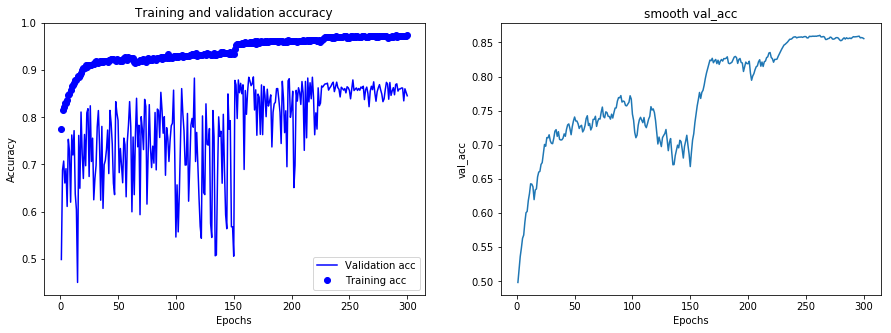

Highest val accuracy: x= 166, y= 0.8857632093933464


<Figure size 432x288 with 0 Axes>

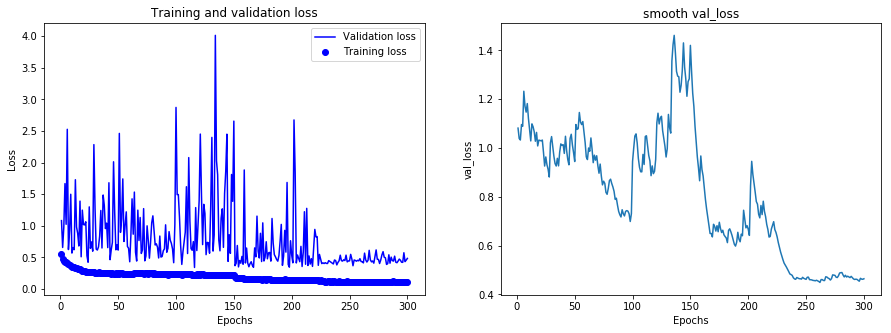

Lowest val loss: x= 115, y= 0.33996726312982595
44468.138698101044


In [14]:
plot_graphs(historyP4M_DenseNet_128)
print(timeP4M_DenseNet_128)

In [15]:
P4M_DenseNet_128.evaluate_generator(test_generator,steps=len(test_generator)-1)

[0.7049507983685006, 0.7985261741682974]

<Figure size 432x288 with 0 Axes>

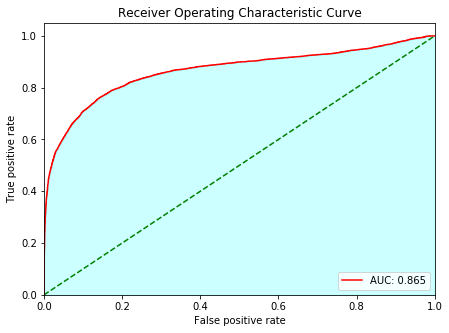

In [16]:
evaluate_auc(P4M_DenseNet_128,test_generator)

In [21]:
P4M_DenseNet_128.load_weights("../model_saves/PCAM/PCam_Dense/P4M_DenseNet_128BestWeights116epochs.hdf5")

In [22]:
P4M_DenseNet_128.evaluate_generator(test_generator,steps=len(test_generator)-1)

[0.4514389558605952, 0.8343933463796478]

<Figure size 432x288 with 0 Axes>

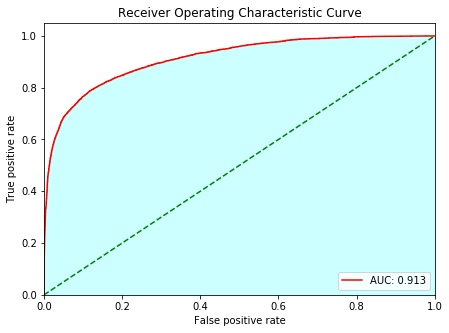

In [23]:
evaluate_auc(P4M_DenseNet_128,test_generator)

#### Model 2 - Rotational train of above

In [16]:
initial_filters = 12
weight_decay = 1e-4 # Setting from the DenseNet paper
P4M_DenseNet_128_Rottrain = build_and_compile_dense_model(initial_filters,growth_rate=16,dense_blocks=5,conv_layers=1,
                                           is_gconv=True,gconv_type="D4",padding="valid",dropout=0.2,img_size=96,
                                           opt="Adam",weight_decay=weight_decay,output="sigmoid",labels=1,bc_model=False)

In [7]:
%%notify

totalepochs=300

historyP4M_DenseNet_128_Rottrain = fit_model_to_directory_generator(P4M_DenseNet_128_Rottrain,train_datagen,tr_dir,validation_generator,
                                           callbacks=callbacks,steps=312,val_steps=len(validation_generator)-1,batch_size=64,epochs=totalepochs,verbose=1)
timeP4M_DenseNet_128_Rottrain = np.sum(time_check.epoch_times)
P4M_DenseNet_128_Rottrain.save_weights("../model_saves/PCAM/PCam_Dense/P4M_DenseNet_128_RottrainFinal.h5")

Found 262144 images belonging to 2 classes.
Epoch 1/300
312/312 [==============================] - 154s 492ms/step - loss: 0.5060 - acc: 0.7917 - val_loss: 0.9291 - val_acc: 0.6300
Epoch 2/300
312/312 [==============================] - 148s 474ms/step - loss: 0.4550 - acc: 0.8178 - val_loss: 0.6914 - val_acc: 0.6784
Epoch 3/300
312/312 [==============================] - 148s 474ms/step - loss: 0.4300 - acc: 0.8287 - val_loss: 0.7010 - val_acc: 0.7545
Epoch 4/300
312/312 [==============================] - 148s 475ms/step - loss: 0.4150 - acc: 0.8349 - val_loss: 1.1965 - val_acc: 0.5903
Epoch 5/300
312/312 [==============================] - 148s 474ms/step - loss: 0.4016 - acc: 0.8380 - val_loss: 0.5863 - val_acc: 0.7437
Epoch 6/300
312/312 [==============================] - 148s 475ms/step - loss: 0.3927 - acc: 0.8421 - val_loss: 0.6156 - val_acc: 0.7834
Epoch 7/300
312/312 [==============================] - 148s 475ms/step - loss: 0.3880 - acc: 0.8456 - val_loss: 0.8060 - val_acc: 0.74

312/312 [==============================] - 147s 471ms/step - loss: 0.1449 - acc: 0.9570 - val_loss: 1.1896 - val_acc: 0.6895
Epoch 119/300
312/312 [==============================] - 147s 471ms/step - loss: 0.1394 - acc: 0.9573 - val_loss: 0.8510 - val_acc: 0.7163
Epoch 120/300
312/312 [==============================] - 147s 471ms/step - loss: 0.1491 - acc: 0.9556 - val_loss: 0.6537 - val_acc: 0.7805
Epoch 121/300
312/312 [==============================] - 147s 471ms/step - loss: 0.1490 - acc: 0.9561 - val_loss: 0.4873 - val_acc: 0.8121
Epoch 122/300
312/312 [==============================] - 147s 472ms/step - loss: 0.1408 - acc: 0.9591 - val_loss: 0.5454 - val_acc: 0.8260
Epoch 123/300
312/312 [==============================] - 147s 472ms/step - loss: 0.1481 - acc: 0.9550 - val_loss: 0.6954 - val_acc: 0.7459
Epoch 124/300
312/312 [==============================] - 147s 471ms/step - loss: 0.1477 - acc: 0.9562 - val_loss: 0.6189 - val_acc: 0.7827
Epoch 125/300
312/312 [==================

312/312 [==============================] - 147s 472ms/step - loss: 0.1131 - acc: 0.9672 - val_loss: 0.9367 - val_acc: 0.7334
Epoch 233/300
312/312 [==============================] - 147s 472ms/step - loss: 0.1146 - acc: 0.9675 - val_loss: 0.9978 - val_acc: 0.7234
Epoch 234/300
312/312 [==============================] - 147s 472ms/step - loss: 0.1169 - acc: 0.9667 - val_loss: 0.9693 - val_acc: 0.7269
Epoch 235/300
312/312 [==============================] - 147s 472ms/step - loss: 0.1164 - acc: 0.9651 - val_loss: 1.0113 - val_acc: 0.7201
Epoch 236/300
312/312 [==============================] - 147s 472ms/step - loss: 0.1168 - acc: 0.9661 - val_loss: 0.9805 - val_acc: 0.7266
Epoch 237/300
312/312 [==============================] - 147s 471ms/step - loss: 0.1232 - acc: 0.9639 - val_loss: 0.9355 - val_acc: 0.7324
Epoch 238/300
312/312 [==============================] - 147s 471ms/step - loss: 0.1142 - acc: 0.9680 - val_loss: 0.9633 - val_acc: 0.7273
Epoch 239/300
312/312 [==================

<IPython.core.display.Javascript object>

<Figure size 432x288 with 0 Axes>

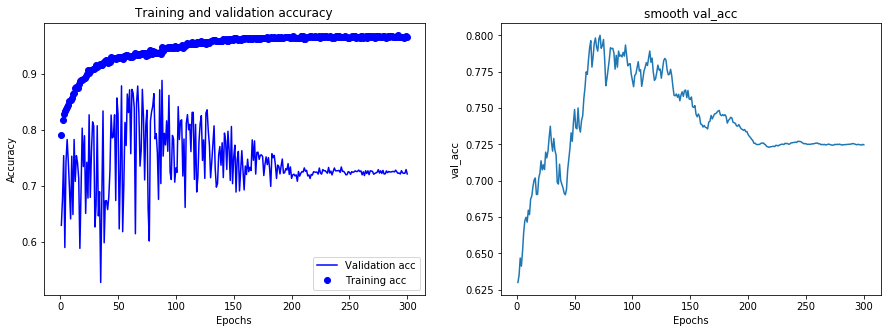

Highest val accuracy: x= 87, y= 0.8889738258317026


<Figure size 432x288 with 0 Axes>

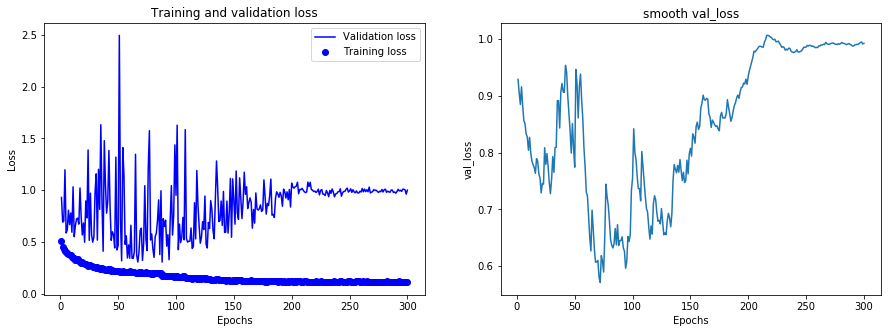

Lowest val loss: x= 87, y= 0.3049274423030258
44163.774374723434


In [8]:
plot_graphs(historyP4M_DenseNet_128_Rottrain)
print(timeP4M_DenseNet_128_Rottrain)

In [17]:
P4M_DenseNet_128_Rottrain.load_weights("../model_saves/PCAM/PCam_Dense/P4M_DenseNet_128_RottrainFinal.h5")

In [7]:
P4M_DenseNet_128_Rottrain.evaluate_generator(test_generator,steps=len(test_generator)-1)

[1.281549068812988, 0.6977433953033269]

<Figure size 432x288 with 0 Axes>

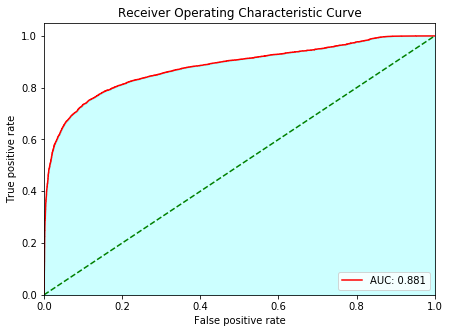

In [8]:
evaluate_auc(P4M_DenseNet_128_Rottrain,test_generator)

In [18]:
P4M_DenseNet_128_Rottrain.load_weights("../model_saves/PCAM/PCam_Dense/P4M_DenseNet_128_RottrainBestWeights80epochs.hdf5")

In [11]:
P4M_DenseNet_128_Rottrain.evaluate_generator(test_generator,steps=len(test_generator)-1)

[0.6096920590053099, 0.8285225048923679]

<Figure size 432x288 with 0 Axes>

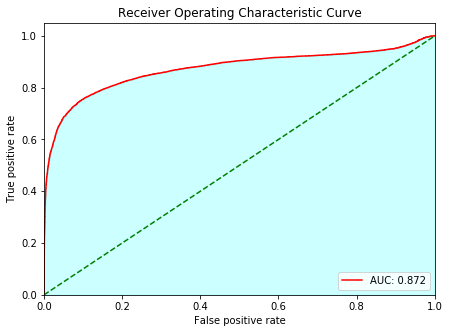

In [19]:
evaluate_auc(P4M_DenseNet_128_Rottrain,test_generator)

#### Model 3 - Dropout increased

In [4]:
initial_filters = 12
weight_decay = 1e-4 # Setting from the DenseNet paper
P4M_DenseNet_128_DROPOUT = build_and_compile_dense_model(initial_filters,growth_rate=16,dense_blocks=5,conv_layers=1,
                                           is_gconv=True,gconv_type="D4",padding="valid",dropout=0.5,img_size=96,
                                           opt="DenseSGD",weight_decay=weight_decay,output="sigmoid",labels=1,bc_model=False)

In [5]:
%%notify

totalepochs=300

historyP4M_DenseNet_128_DROPOUT = fit_model_to_directory_generator(P4M_DenseNet_128_DROPOUT,train_datagen,tr_dir,validation_generator,
                                           callbacks=callbacks,steps=312,val_steps=len(validation_generator)-1,batch_size=64,epochs=totalepochs,verbose=1)
timeP4M_DenseNet_128_DROPOUT = np.sum(time_check.epoch_times)
P4M_DenseNet_128_DROPOUT.save_weights("../model_saves/PCAM/PCam_Dense/P4M_DenseNet_128_DROPOUTFinal.h5")

Found 262144 images belonging to 2 classes.
Epoch 1/300

Epoch 00001: LearningRateScheduler setting learning rate to 0.10000000149011612.
312/312 [==============================] - 160s 511ms/step - loss: 0.5249 - acc: 0.7839 - val_loss: 3.0889 - val_acc: 0.5292
Epoch 2/300

Epoch 00002: LearningRateScheduler setting learning rate to 0.10000000149011612.
312/312 [==============================] - 150s 481ms/step - loss: 0.4807 - acc: 0.8108 - val_loss: 1.2778 - val_acc: 0.6239
Epoch 3/300

Epoch 00003: LearningRateScheduler setting learning rate to 0.10000000149011612.
312/312 [==============================] - 150s 482ms/step - loss: 0.4504 - acc: 0.8238 - val_loss: 2.5616 - val_acc: 0.5457
Epoch 4/300

Epoch 00004: LearningRateScheduler setting learning rate to 0.10000000149011612.
312/312 [==============================] - 149s 479ms/step - loss: 0.4458 - acc: 0.8231 - val_loss: 3.7019 - val_acc: 0.5390
Epoch 5/300

Epoch 00005: LearningRateScheduler setting learning rate to 0.10000

312/312 [==============================] - 146s 469ms/step - loss: 0.2901 - acc: 0.9006 - val_loss: 0.5796 - val_acc: 0.7625
Epoch 39/300

Epoch 00039: LearningRateScheduler setting learning rate to 0.10000000149011612.
312/312 [==============================] - 146s 469ms/step - loss: 0.2779 - acc: 0.9041 - val_loss: 0.8920 - val_acc: 0.6990
Epoch 40/300

Epoch 00040: LearningRateScheduler setting learning rate to 0.10000000149011612.
312/312 [==============================] - 146s 469ms/step - loss: 0.2777 - acc: 0.9066 - val_loss: 1.2597 - val_acc: 0.5304
Epoch 41/300

Epoch 00041: LearningRateScheduler setting learning rate to 0.10000000149011612.
312/312 [==============================] - 147s 470ms/step - loss: 0.2841 - acc: 0.9021 - val_loss: 0.6856 - val_acc: 0.7194
Epoch 42/300

Epoch 00042: LearningRateScheduler setting learning rate to 0.10000000149011612.
312/312 [==============================] - 146s 469ms/step - loss: 0.2788 - acc: 0.9052 - val_loss: 0.4424 - val_acc: 0.

312/312 [==============================] - 146s 469ms/step - loss: 0.2437 - acc: 0.9235 - val_loss: 0.6237 - val_acc: 0.8158
Epoch 113/300

Epoch 00113: LearningRateScheduler setting learning rate to 0.10000000149011612.
312/312 [==============================] - 146s 469ms/step - loss: 0.2472 - acc: 0.9221 - val_loss: 0.7475 - val_acc: 0.6952
Epoch 114/300

Epoch 00114: LearningRateScheduler setting learning rate to 0.10000000149011612.
312/312 [==============================] - 146s 469ms/step - loss: 0.2420 - acc: 0.9252 - val_loss: 0.5187 - val_acc: 0.8182
Epoch 115/300

Epoch 00115: LearningRateScheduler setting learning rate to 0.10000000149011612.
312/312 [==============================] - 146s 469ms/step - loss: 0.2453 - acc: 0.9236 - val_loss: 0.6083 - val_acc: 0.7636
Epoch 116/300

Epoch 00116: LearningRateScheduler setting learning rate to 0.10000000149011612.
312/312 [==============================] - 146s 469ms/step - loss: 0.2400 - acc: 0.9247 - val_loss: 1.2451 - val_acc

312/312 [==============================] - 146s 469ms/step - loss: 0.1694 - acc: 0.9533 - val_loss: 0.5985 - val_acc: 0.8123
Epoch 187/300

Epoch 00187: LearningRateScheduler setting learning rate to 0.009999999776482582.
312/312 [==============================] - 146s 469ms/step - loss: 0.1660 - acc: 0.9536 - val_loss: 1.3203 - val_acc: 0.7108
Epoch 188/300

Epoch 00188: LearningRateScheduler setting learning rate to 0.009999999776482582.
312/312 [==============================] - 146s 469ms/step - loss: 0.1692 - acc: 0.9509 - val_loss: 0.6725 - val_acc: 0.8111
Epoch 189/300

Epoch 00189: LearningRateScheduler setting learning rate to 0.009999999776482582.
312/312 [==============================] - 146s 469ms/step - loss: 0.1640 - acc: 0.9533 - val_loss: 0.6752 - val_acc: 0.8091
Epoch 190/300

Epoch 00190: LearningRateScheduler setting learning rate to 0.009999999776482582.
312/312 [==============================] - 146s 469ms/step - loss: 0.1669 - acc: 0.9525 - val_loss: 0.5415 - val

312/312 [==============================] - 148s 474ms/step - loss: 0.1591 - acc: 0.9522 - val_loss: 0.9098 - val_acc: 0.8003
Epoch 224/300

Epoch 00224: LearningRateScheduler setting learning rate to 0.009999999776482582.
312/312 [==============================] - 148s 475ms/step - loss: 0.1557 - acc: 0.9537 - val_loss: 0.4653 - val_acc: 0.8487
Epoch 225/300

Epoch 00225: LearningRateScheduler setting learning rate to 0.009999999776482582.
312/312 [==============================] - 148s 474ms/step - loss: 0.1553 - acc: 0.9534 - val_loss: 1.1741 - val_acc: 0.7289
Epoch 226/300

Epoch 00226: LearningRateScheduler setting learning rate to 0.0009999999776482583.
312/312 [==============================] - 148s 475ms/step - loss: 0.1453 - acc: 0.9581 - val_loss: 0.8634 - val_acc: 0.7763
Epoch 227/300

Epoch 00227: LearningRateScheduler setting learning rate to 0.0009999999310821295.
312/312 [==============================] - 148s 474ms/step - loss: 0.1444 - acc: 0.9586 - val_loss: 1.1055 - v

312/312 [==============================] - 148s 475ms/step - loss: 0.1334 - acc: 0.9618 - val_loss: 1.1893 - val_acc: 0.7425
Epoch 261/300

Epoch 00261: LearningRateScheduler setting learning rate to 0.0009999999310821295.
312/312 [==============================] - 148s 475ms/step - loss: 0.1350 - acc: 0.9618 - val_loss: 1.0726 - val_acc: 0.7725
Epoch 262/300

Epoch 00262: LearningRateScheduler setting learning rate to 0.0009999999310821295.
312/312 [==============================] - 148s 474ms/step - loss: 0.1311 - acc: 0.9641 - val_loss: 1.4601 - val_acc: 0.7294
Epoch 263/300

Epoch 00263: LearningRateScheduler setting learning rate to 0.0009999999310821295.
312/312 [==============================] - 148s 476ms/step - loss: 0.1263 - acc: 0.9657 - val_loss: 1.0636 - val_acc: 0.7646
Epoch 264/300

Epoch 00264: LearningRateScheduler setting learning rate to 0.0009999999310821295.
312/312 [==============================] - 149s 477ms/step - loss: 0.1327 - acc: 0.9627 - val_loss: 1.4835 -

312/312 [==============================] - 148s 474ms/step - loss: 0.1331 - acc: 0.9629 - val_loss: 1.2837 - val_acc: 0.7428
Epoch 298/300

Epoch 00298: LearningRateScheduler setting learning rate to 0.0009999999310821295.
312/312 [==============================] - 148s 474ms/step - loss: 0.1303 - acc: 0.9626 - val_loss: 1.3699 - val_acc: 0.7317
Epoch 299/300

Epoch 00299: LearningRateScheduler setting learning rate to 0.0009999999310821295.
312/312 [==============================] - 148s 476ms/step - loss: 0.1320 - acc: 0.9628 - val_loss: 1.1595 - val_acc: 0.7553
Epoch 300/300

Epoch 00300: LearningRateScheduler setting learning rate to 0.0009999999310821295.
312/312 [==============================] - 148s 474ms/step - loss: 0.1282 - acc: 0.9643 - val_loss: 1.0831 - val_acc: 0.7647


<IPython.core.display.Javascript object>

In [6]:
P4M_DenseNet_128_DROPOUT.evaluate_generator(test_generator,steps=len(test_generator)-1)

[1.5714849526401602, 0.7088735322896281]

<Figure size 432x288 with 0 Axes>

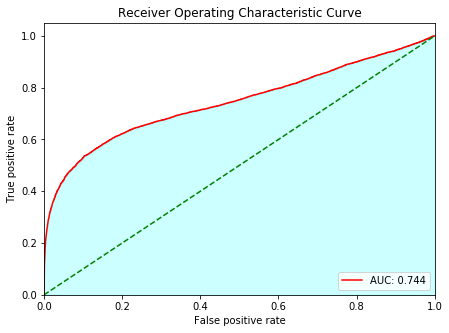

In [8]:
evaluate_auc(P4M_DenseNet_128_DROPOUT,test_generator)

In [9]:
P4M_DenseNet_128_DROPOUT.load_weights("../model_saves/PCAM/PCam_Dense/P4M_DenseNet_128_DROPOUTBestWeights68epochs.hdf5")

In [10]:
P4M_DenseNet_128_DROPOUT.evaluate_generator(test_generator,steps=len(test_generator)-1)

[0.3964777705195832, 0.8539016634050881]

<Figure size 432x288 with 0 Axes>

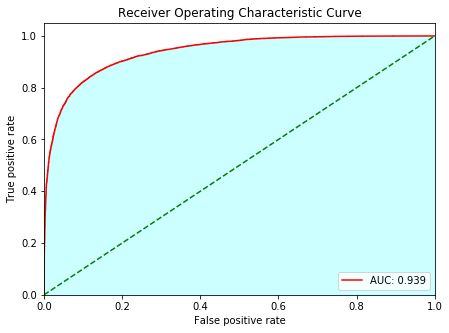

In [11]:
evaluate_auc(P4M_DenseNet_128_DROPOUT,test_generator)

# Models with growth rate 6 <a class="anchor" id="gr6"></a>
----------------------------------

#### DenseSGD training

In [4]:
initial_filters = 12
weight_decay = 1e-4 # Setting from the DenseNet paper
P4M_DenseNet_48 = build_and_compile_dense_model(initial_filters,growth_rate=6,dense_blocks=5,conv_layers=1,
                                           is_gconv=True,gconv_type="D4",padding="valid",dropout=0.2,img_size=96,
                                           opt="DenseSGD",weight_decay=weight_decay,output="sigmoid",labels=1,bc_model=False)

In [5]:
P4M_DenseNet_48.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 96, 96, 3)    0                                            
__________________________________________________________________________________________________
g_conv2d_1 (GConv2D)            (None, 94, 94, 96)   324         input_1[0][0]                    
__________________________________________________________________________________________________
g_batch_norm_1 (GBatchNorm)     (None, 94, 94, 96)   96          g_conv2d_1[0][0]                 
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 94, 94, 96)   0           g_batch_norm_1[0][0]             
__________________________________________________________________________________________________
g_conv2d_2

In [6]:
%%notify

totalepochs=300

historyP4M_DenseNet_48 = fit_model_to_directory_generator(P4M_DenseNet_48,train_datagen,tr_dir,validation_generator,
                                           callbacks=callbacks,steps=312,val_steps=len(validation_generator)-1,batch_size=64,epochs=totalepochs,verbose=1)
timeP4M_DenseNet_48 = np.sum(time_check.epoch_times)
P4M_DenseNet_48.save_weights("../model_saves/PCAM/PCAM_DENSE/P4M_DenseNet_48Final.h5")

Found 262144 images belonging to 2 classes.
Epoch 1/300

Epoch 00001: LearningRateScheduler setting learning rate to 0.10000000149011612.
312/312 [==============================] - 98s 313ms/step - loss: 0.5105 - acc: 0.7768 - val_loss: 0.6772 - val_acc: 0.6407
Epoch 2/300

Epoch 00002: LearningRateScheduler setting learning rate to 0.10000000149011612.
312/312 [==============================] - 94s 302ms/step - loss: 0.4433 - acc: 0.8149 - val_loss: 0.7726 - val_acc: 0.7018
Epoch 3/300

Epoch 00003: LearningRateScheduler setting learning rate to 0.10000000149011612.
312/312 [==============================] - 94s 302ms/step - loss: 0.4201 - acc: 0.8272 - val_loss: 1.6506 - val_acc: 0.5163
Epoch 4/300

Epoch 00004: LearningRateScheduler setting learning rate to 0.10000000149011612.
312/312 [==============================] - 94s 301ms/step - loss: 0.4048 - acc: 0.8336 - val_loss: 0.5227 - val_acc: 0.7702
Epoch 5/300

Epoch 00005: LearningRateScheduler setting learning rate to 0.100000001

312/312 [==============================] - 95s 303ms/step - loss: 0.2558 - acc: 0.9166 - val_loss: 1.9885 - val_acc: 0.5006
Epoch 39/300

Epoch 00039: LearningRateScheduler setting learning rate to 0.10000000149011612.
312/312 [==============================] - 94s 302ms/step - loss: 0.2506 - acc: 0.9187 - val_loss: 0.3331 - val_acc: 0.8746
Epoch 40/300

Epoch 00040: LearningRateScheduler setting learning rate to 0.10000000149011612.
312/312 [==============================] - 94s 302ms/step - loss: 0.2496 - acc: 0.9165 - val_loss: 0.5603 - val_acc: 0.7796
Epoch 41/300

Epoch 00041: LearningRateScheduler setting learning rate to 0.10000000149011612.
312/312 [==============================] - 94s 302ms/step - loss: 0.2458 - acc: 0.9198 - val_loss: 0.3663 - val_acc: 0.8527
Epoch 42/300

Epoch 00042: LearningRateScheduler setting learning rate to 0.10000000149011612.
312/312 [==============================] - 94s 302ms/step - loss: 0.2586 - acc: 0.9136 - val_loss: 0.6854 - val_acc: 0.7612


Epoch 76/300

Epoch 00076: LearningRateScheduler setting learning rate to 0.10000000149011612.
312/312 [==============================] - 92s 295ms/step - loss: 0.2373 - acc: 0.9242 - val_loss: 0.4360 - val_acc: 0.8132
Epoch 77/300

Epoch 00077: LearningRateScheduler setting learning rate to 0.10000000149011612.
312/312 [==============================] - 92s 294ms/step - loss: 0.2360 - acc: 0.9259 - val_loss: 1.1853 - val_acc: 0.6021
Epoch 78/300

Epoch 00078: LearningRateScheduler setting learning rate to 0.10000000149011612.
312/312 [==============================] - 91s 293ms/step - loss: 0.2373 - acc: 0.9245 - val_loss: 0.5295 - val_acc: 0.8095
Epoch 79/300

Epoch 00079: LearningRateScheduler setting learning rate to 0.10000000149011612.
312/312 [==============================] - 91s 293ms/step - loss: 0.2429 - acc: 0.9207 - val_loss: 0.7269 - val_acc: 0.5801
Epoch 80/300

Epoch 00080: LearningRateScheduler setting learning rate to 0.10000000149011612.
312/312 [====================

312/312 [==============================] - 91s 293ms/step - loss: 0.2366 - acc: 0.9258 - val_loss: 1.4535 - val_acc: 0.5071
Epoch 114/300

Epoch 00114: LearningRateScheduler setting learning rate to 0.10000000149011612.
312/312 [==============================] - 91s 293ms/step - loss: 0.2301 - acc: 0.9288 - val_loss: 0.4232 - val_acc: 0.8372
Epoch 115/300

Epoch 00115: LearningRateScheduler setting learning rate to 0.10000000149011612.
312/312 [==============================] - 92s 293ms/step - loss: 0.2257 - acc: 0.9317 - val_loss: 0.6470 - val_acc: 0.6934
Epoch 116/300

Epoch 00116: LearningRateScheduler setting learning rate to 0.10000000149011612.
312/312 [==============================] - 92s 293ms/step - loss: 0.2294 - acc: 0.9296 - val_loss: 0.8141 - val_acc: 0.7424
Epoch 117/300

Epoch 00117: LearningRateScheduler setting learning rate to 0.10000000149011612.
312/312 [==============================] - 91s 293ms/step - loss: 0.2320 - acc: 0.9278 - val_loss: 1.4197 - val_acc: 0.5

312/312 [==============================] - 94s 302ms/step - loss: 0.1647 - acc: 0.9512 - val_loss: 0.3978 - val_acc: 0.8470
Epoch 188/300

Epoch 00188: LearningRateScheduler setting learning rate to 0.009999999776482582.
312/312 [==============================] - 94s 302ms/step - loss: 0.1629 - acc: 0.9534 - val_loss: 0.2967 - val_acc: 0.8901
Epoch 189/300

Epoch 00189: LearningRateScheduler setting learning rate to 0.009999999776482582.
312/312 [==============================] - 94s 302ms/step - loss: 0.1720 - acc: 0.9479 - val_loss: 0.3944 - val_acc: 0.8346
Epoch 190/300

Epoch 00190: LearningRateScheduler setting learning rate to 0.009999999776482582.
312/312 [==============================] - 94s 302ms/step - loss: 0.1661 - acc: 0.9526 - val_loss: 0.4697 - val_acc: 0.8242
Epoch 191/300

Epoch 00191: LearningRateScheduler setting learning rate to 0.009999999776482582.
312/312 [==============================] - 94s 302ms/step - loss: 0.1611 - acc: 0.9526 - val_loss: 0.3819 - val_acc:

312/312 [==============================] - 95s 304ms/step - loss: 0.1308 - acc: 0.9624 - val_loss: 0.3172 - val_acc: 0.8819
Epoch 262/300

Epoch 00262: LearningRateScheduler setting learning rate to 0.0009999999310821295.
312/312 [==============================] - 95s 304ms/step - loss: 0.1334 - acc: 0.9622 - val_loss: 0.3140 - val_acc: 0.8881
Epoch 263/300

Epoch 00263: LearningRateScheduler setting learning rate to 0.0009999999310821295.
312/312 [==============================] - 95s 303ms/step - loss: 0.1398 - acc: 0.9600 - val_loss: 0.2879 - val_acc: 0.8971
Epoch 264/300

Epoch 00264: LearningRateScheduler setting learning rate to 0.0009999999310821295.
312/312 [==============================] - 95s 303ms/step - loss: 0.1394 - acc: 0.9597 - val_loss: 0.3587 - val_acc: 0.8684
Epoch 265/300

Epoch 00265: LearningRateScheduler setting learning rate to 0.0009999999310821295.
312/312 [==============================] - 95s 304ms/step - loss: 0.1356 - acc: 0.9612 - val_loss: 0.3711 - val_

312/312 [==============================] - 95s 303ms/step - loss: 0.1351 - acc: 0.9614 - val_loss: 0.3414 - val_acc: 0.8786
Epoch 299/300

Epoch 00299: LearningRateScheduler setting learning rate to 0.0009999999310821295.
312/312 [==============================] - 95s 304ms/step - loss: 0.1284 - acc: 0.9634 - val_loss: 0.4279 - val_acc: 0.8361
Epoch 300/300

Epoch 00300: LearningRateScheduler setting learning rate to 0.0009999999310821295.
312/312 [==============================] - 95s 306ms/step - loss: 0.1337 - acc: 0.9619 - val_loss: 0.4049 - val_acc: 0.8461


OSError: Unable to create file (unable to open file: name = 'model_saves/PCAM/PCAM_DENSE/P4M_DenseNet_48Final.h5', errno = 2, error message = 'No such file or directory', flags = 13, o_flags = 302)

<IPython.core.display.Javascript object>

<Figure size 432x288 with 0 Axes>

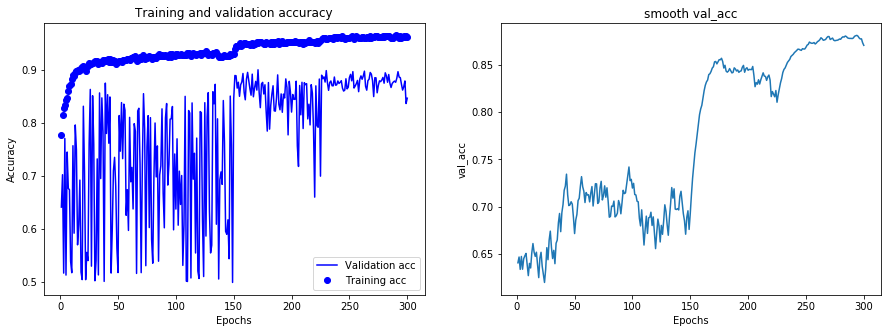

Highest val accuracy: x= 170, y= 0.8997370352250489


<Figure size 432x288 with 0 Axes>

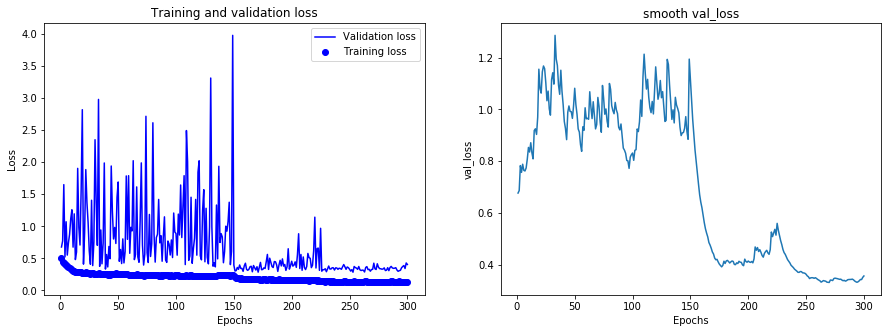

Lowest val loss: x= 252, y= 0.2840816599923804
28087.906513929367


In [7]:
plot_graphs(historyP4M_DenseNet_48)
print(timeP4M_DenseNet_48)

In [8]:
P4M_DenseNet_48.evaluate_generator(test_generator,steps=len(test_generator)-1)

[0.5422880952547208, 0.8209699119373777]

<Figure size 432x288 with 0 Axes>

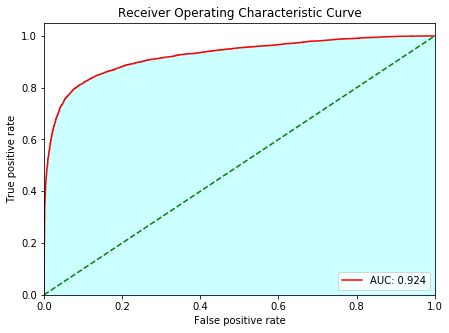

In [9]:
evaluate_auc(P4M_DenseNet_48,test_generator)

In [10]:
P4M_DenseNet_48.load_weights("../model_saves/PCAM/PCAM_Dense/P4M_DenseNet_48BestWeights253epochs.hdf5")

In [11]:
P4M_DenseNet_48.evaluate_generator(test_generator,steps=len(test_generator)-1)

[0.3743295972827829, 0.86010885518591]

<Figure size 432x288 with 0 Axes>

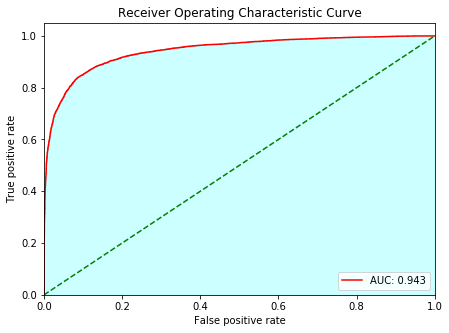

In [12]:
evaluate_auc(P4M_DenseNet_48,test_generator)

#### Rotational paper training

In [5]:
callbacks = [time_check,
            keras.callbacks.ModelCheckpoint(
                filepath="../model_saves/PCAM/PCAM_Dense/weights.{epoch:02d}-{val_loss:.2f}.hdf5",
                monitor='val_loss',
                save_best_only=True),
             lr_mod
            ]

In [6]:
initial_filters = 12
weight_decay = 1e-4 # Setting from the DenseNet paper
P4M_DenseNet_48_ROTTRAIN = build_and_compile_dense_model(initial_filters,growth_rate=6,dense_blocks=5,conv_layers=1,
                                           is_gconv=True,gconv_type="D4",padding="valid",dropout=0.2,img_size=96,
                                           opt="Adam",weight_decay=weight_decay,output="sigmoid",labels=1,bc_model=False)

In [7]:
P4M_DenseNet_48_ROTTRAIN.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 96, 96, 3)    0                                            
__________________________________________________________________________________________________
g_conv2d_1 (GConv2D)            (None, 94, 94, 96)   324         input_1[0][0]                    
__________________________________________________________________________________________________
g_batch_norm_1 (GBatchNorm)     (None, 94, 94, 96)   96          g_conv2d_1[0][0]                 
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 94, 94, 96)   0           g_batch_norm_1[0][0]             
__________________________________________________________________________________________________
g_conv2d_2

In [8]:
%%notify

totalepochs=300

historyP4M_DenseNet_48_ROTTRAIN = fit_model_to_directory_generator(P4M_DenseNet_48_ROTTRAIN,train_datagen,tr_dir,validation_generator,
                                           callbacks=callbacks,steps=312,val_steps=len(validation_generator)-1,batch_size=64,epochs=totalepochs,verbose=1)
timeP4M_DenseNet_48_ROTTRAIN = np.sum(time_check.epoch_times)
P4M_DenseNet_48_ROTTRAIN.save_weights("../model_saves/PCAM/PCAM_Dense/P4M_DenseNet_48_ROTTRAINFinal.h5")

Found 262144 images belonging to 2 classes.
Epoch 1/300
312/312 [==============================] - 97s 311ms/step - loss: 0.4943 - acc: 0.7807 - val_loss: 0.5685 - val_acc: 0.7561
Epoch 2/300
312/312 [==============================] - 93s 297ms/step - loss: 0.4361 - acc: 0.8180 - val_loss: 0.7954 - val_acc: 0.6097
Epoch 3/300
312/312 [==============================] - 93s 297ms/step - loss: 0.4174 - acc: 0.8265 - val_loss: 0.4867 - val_acc: 0.7852
Epoch 4/300
312/312 [==============================] - 93s 297ms/step - loss: 0.3891 - acc: 0.8428 - val_loss: 1.3080 - val_acc: 0.5062
Epoch 5/300
312/312 [==============================] - 93s 297ms/step - loss: 0.3663 - acc: 0.8538 - val_loss: 0.9130 - val_acc: 0.6678
Epoch 6/300
312/312 [==============================] - 93s 297ms/step - loss: 0.3408 - acc: 0.8651 - val_loss: 0.5334 - val_acc: 0.7581
Epoch 7/300
312/312 [==============================] - 92s 296ms/step - loss: 0.3210 - acc: 0.8750 - val_loss: 0.9672 - val_acc: 0.6810
Epoc

312/312 [==============================] - 92s 294ms/step - loss: 0.1797 - acc: 0.9417 - val_loss: 0.8443 - val_acc: 0.7675
Epoch 61/300
312/312 [==============================] - 92s 294ms/step - loss: 0.1796 - acc: 0.9418 - val_loss: 0.3135 - val_acc: 0.8849
Epoch 62/300
312/312 [==============================] - 92s 295ms/step - loss: 0.1865 - acc: 0.9388 - val_loss: 0.9380 - val_acc: 0.6808
Epoch 63/300
312/312 [==============================] - 92s 294ms/step - loss: 0.1724 - acc: 0.9417 - val_loss: 0.5508 - val_acc: 0.8038
Epoch 64/300
312/312 [==============================] - 92s 294ms/step - loss: 0.1748 - acc: 0.9427 - val_loss: 0.6050 - val_acc: 0.7909
Epoch 65/300
312/312 [==============================] - 92s 294ms/step - loss: 0.1754 - acc: 0.9434 - val_loss: 0.4725 - val_acc: 0.8357
Epoch 66/300
312/312 [==============================] - 92s 294ms/step - loss: 0.1712 - acc: 0.9454 - val_loss: 1.1265 - val_acc: 0.6829
Epoch 67/300
312/312 [==============================] 

Epoch 119/300
312/312 [==============================] - 92s 294ms/step - loss: 0.1381 - acc: 0.9580 - val_loss: 0.6170 - val_acc: 0.8103
Epoch 120/300
312/312 [==============================] - 92s 295ms/step - loss: 0.1431 - acc: 0.9572 - val_loss: 0.2937 - val_acc: 0.8928
Epoch 121/300
312/312 [==============================] - 92s 294ms/step - loss: 0.1410 - acc: 0.9566 - val_loss: 0.6665 - val_acc: 0.7820
Epoch 122/300
312/312 [==============================] - 92s 294ms/step - loss: 0.1342 - acc: 0.9590 - val_loss: 0.3061 - val_acc: 0.8909
Epoch 123/300
312/312 [==============================] - 92s 294ms/step - loss: 0.1398 - acc: 0.9566 - val_loss: 0.8349 - val_acc: 0.7681
Epoch 124/300
312/312 [==============================] - 92s 294ms/step - loss: 0.1422 - acc: 0.9555 - val_loss: 0.3387 - val_acc: 0.8764
Epoch 125/300
312/312 [==============================] - 92s 294ms/step - loss: 0.1410 - acc: 0.9571 - val_loss: 1.1381 - val_acc: 0.6851
Learn rate updated from 0.00012500

Epoch 177/300
312/312 [==============================] - 92s 294ms/step - loss: 0.1316 - acc: 0.9627 - val_loss: 0.5333 - val_acc: 0.8227
Epoch 178/300
312/312 [==============================] - 92s 294ms/step - loss: 0.1220 - acc: 0.9637 - val_loss: 0.4618 - val_acc: 0.8379
Epoch 179/300
312/312 [==============================] - 92s 294ms/step - loss: 0.1239 - acc: 0.9631 - val_loss: 0.4368 - val_acc: 0.8468
Epoch 180/300
312/312 [==============================] - 92s 294ms/step - loss: 0.1284 - acc: 0.9610 - val_loss: 0.4702 - val_acc: 0.8436
Epoch 181/300
312/312 [==============================] - 92s 294ms/step - loss: 0.1198 - acc: 0.9661 - val_loss: 0.4504 - val_acc: 0.8468
Epoch 182/300
312/312 [==============================] - 92s 294ms/step - loss: 0.1274 - acc: 0.9610 - val_loss: 0.4422 - val_acc: 0.8481
Epoch 183/300
312/312 [==============================] - 92s 294ms/step - loss: 0.1255 - acc: 0.9619 - val_loss: 0.4110 - val_acc: 0.8533
Epoch 184/300
312/312 [===========

Epoch 235/300
312/312 [==============================] - 92s 294ms/step - loss: 0.1220 - acc: 0.9626 - val_loss: 0.4399 - val_acc: 0.8495
Epoch 236/300
312/312 [==============================] - 92s 294ms/step - loss: 0.1240 - acc: 0.9639 - val_loss: 0.4503 - val_acc: 0.8435
Epoch 237/300
312/312 [==============================] - 92s 294ms/step - loss: 0.1248 - acc: 0.9620 - val_loss: 0.4569 - val_acc: 0.8435
Epoch 238/300
312/312 [==============================] - 92s 294ms/step - loss: 0.1236 - acc: 0.9627 - val_loss: 0.4545 - val_acc: 0.8445
Epoch 239/300
312/312 [==============================] - 92s 294ms/step - loss: 0.1219 - acc: 0.9641 - val_loss: 0.4543 - val_acc: 0.8446
Epoch 240/300
312/312 [==============================] - 92s 294ms/step - loss: 0.1195 - acc: 0.9637 - val_loss: 0.4555 - val_acc: 0.8449
Epoch 241/300
312/312 [==============================] - 92s 294ms/step - loss: 0.1251 - acc: 0.9633 - val_loss: 0.4347 - val_acc: 0.8498
Epoch 242/300
312/312 [===========

Epoch 293/300
312/312 [==============================] - 92s 294ms/step - loss: 0.1196 - acc: 0.9655 - val_loss: 0.4565 - val_acc: 0.8441
Epoch 294/300
312/312 [==============================] - 92s 294ms/step - loss: 0.1196 - acc: 0.9652 - val_loss: 0.4438 - val_acc: 0.8460
Epoch 295/300
312/312 [==============================] - 92s 294ms/step - loss: 0.1246 - acc: 0.9629 - val_loss: 0.4543 - val_acc: 0.8440
Epoch 296/300
312/312 [==============================] - 92s 294ms/step - loss: 0.1204 - acc: 0.9654 - val_loss: 0.4509 - val_acc: 0.8444
Epoch 297/300
312/312 [==============================] - 92s 294ms/step - loss: 0.1236 - acc: 0.9624 - val_loss: 0.4482 - val_acc: 0.8444
Epoch 298/300
312/312 [==============================] - 92s 294ms/step - loss: 0.1255 - acc: 0.9630 - val_loss: 0.4499 - val_acc: 0.8448
Epoch 299/300
312/312 [==============================] - 92s 294ms/step - loss: 0.1281 - acc: 0.9612 - val_loss: 0.4590 - val_acc: 0.8428
Epoch 300/300
312/312 [===========

<IPython.core.display.Javascript object>

<Figure size 432x288 with 0 Axes>

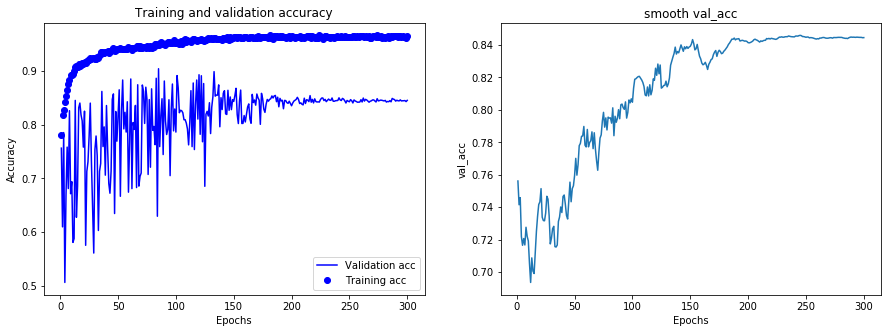

Highest val accuracy: x= 84, y= 0.9039872798434442


<Figure size 432x288 with 0 Axes>

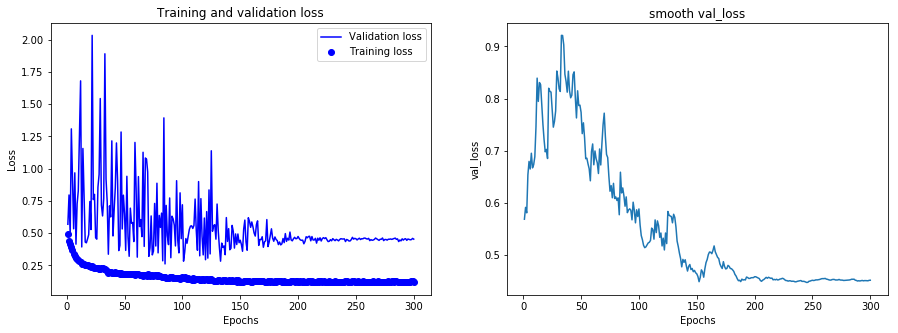

Lowest val loss: x= 84, y= 0.2612164761368076
27564.77195572853


In [9]:
plot_graphs(historyP4M_DenseNet_48_ROTTRAIN)
print(timeP4M_DenseNet_48_ROTTRAIN)

In [10]:
P4M_DenseNet_48_ROTTRAIN.evaluate_generator(test_generator,steps=len(test_generator)-1)

[0.7604753073530888, 0.7830846379647749]

<Figure size 432x288 with 0 Axes>

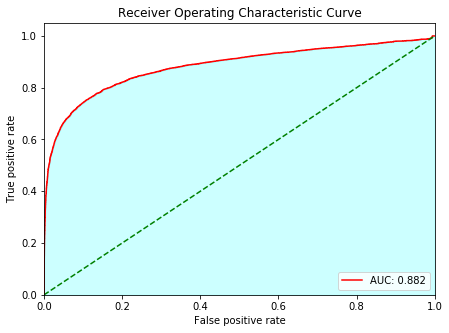

In [11]:
evaluate_auc(P4M_DenseNet_48_ROTTRAIN,test_generator)

In [12]:
P4M_DenseNet_48_ROTTRAIN.load_weights("../model_saves/PCAM/PCAM_Dense/P4M_DenseNet_48_ROTTRAINBestWeights85epochs.hdf5")

In [13]:
P4M_DenseNet_48_ROTTRAIN.evaluate_generator(test_generator,steps=len(test_generator)-1)

[0.4387847225959987, 0.8511191291585127]

<Figure size 432x288 with 0 Axes>

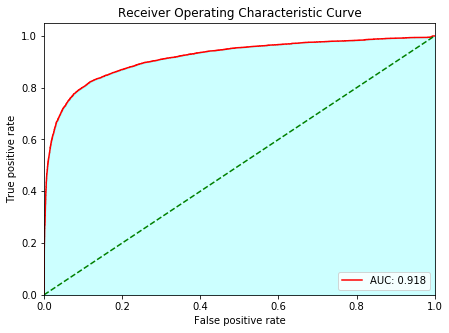

In [14]:
evaluate_auc(P4M_DenseNet_48_ROTTRAIN,test_generator)

#### Dropout model

In [9]:
initial_filters = 12
weight_decay = 1e-4 # Setting from the DenseNet paper
P4M_DenseNet_48_DROPOUT = build_and_compile_dense_model(initial_filters,growth_rate=6,dense_blocks=5,conv_layers=1,
                                           is_gconv=True,gconv_type="D4",padding="valid",dropout=0.5,img_size=96,
                                           opt="DenseSGD",weight_decay=weight_decay,output="sigmoid",labels=1,bc_model=False)

In [10]:
P4M_DenseNet_48_DROPOUT.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 96, 96, 3)    0                                            
__________________________________________________________________________________________________
g_conv2d_1 (GConv2D)            (None, 94, 94, 96)   324         input_1[0][0]                    
__________________________________________________________________________________________________
g_batch_norm_1 (GBatchNorm)     (None, 94, 94, 96)   96          g_conv2d_1[0][0]                 
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 94, 94, 96)   0           g_batch_norm_1[0][0]             
__________________________________________________________________________________________________
g_conv2d_2

In [11]:
%%notify

totalepochs=400

historyP4M_DenseNet_48_DROPOUT = fit_model_to_directory_generator(P4M_DenseNet_48_DROPOUT,train_datagen,tr_dir,validation_generator,
                                           callbacks=callbacks,steps=312,val_steps=len(validation_generator)-1,batch_size=64,epochs=totalepochs,verbose=1)
timeP4M_DenseNet_48_DROPOUT = np.sum(time_check.epoch_times)
P4M_DenseNet_48_DROPOUT.save_weights("../model_saves/PCAM/PCAM_Dense/P4M_DenseNet_48_DROPOUTFinal.h5")

Found 262144 images belonging to 2 classes.
Epoch 1/400

Epoch 00001: LearningRateScheduler setting learning rate to 0.10000000149011612.
312/312 [==============================] - 98s 315ms/step - loss: 0.5044 - acc: 0.7820 - val_loss: 1.2599 - val_acc: 0.6184
Epoch 2/400

Epoch 00002: LearningRateScheduler setting learning rate to 0.10000000149011612.
312/312 [==============================] - 94s 302ms/step - loss: 0.4430 - acc: 0.8164 - val_loss: 1.2301 - val_acc: 0.5631
Epoch 3/400

Epoch 00003: LearningRateScheduler setting learning rate to 0.10000000149011612.
312/312 [==============================] - 94s 302ms/step - loss: 0.4277 - acc: 0.8228 - val_loss: 0.7577 - val_acc: 0.7666
Epoch 4/400

Epoch 00004: LearningRateScheduler setting learning rate to 0.10000000149011612.
312/312 [==============================] - 94s 301ms/step - loss: 0.4105 - acc: 0.8334 - val_loss: 0.6518 - val_acc: 0.7190
Epoch 5/400

Epoch 00005: LearningRateScheduler setting learning rate to 0.100000001

312/312 [==============================] - 91s 293ms/step - loss: 0.2788 - acc: 0.9029 - val_loss: 0.5957 - val_acc: 0.8023
Epoch 39/400

Epoch 00039: LearningRateScheduler setting learning rate to 0.10000000149011612.
312/312 [==============================] - 91s 293ms/step - loss: 0.2769 - acc: 0.9065 - val_loss: 1.3524 - val_acc: 0.5049
Epoch 40/400

Epoch 00040: LearningRateScheduler setting learning rate to 0.10000000149011612.
312/312 [==============================] - 91s 293ms/step - loss: 0.2691 - acc: 0.9112 - val_loss: 0.6322 - val_acc: 0.7384
Epoch 41/400

Epoch 00041: LearningRateScheduler setting learning rate to 0.10000000149011612.
312/312 [==============================] - 91s 293ms/step - loss: 0.2733 - acc: 0.9094 - val_loss: 0.9261 - val_acc: 0.7343
Epoch 42/400

Epoch 00042: LearningRateScheduler setting learning rate to 0.10000000149011612.
312/312 [==============================] - 91s 293ms/step - loss: 0.2724 - acc: 0.9075 - val_loss: 1.4597 - val_acc: 0.7133


Epoch 76/400

Epoch 00076: LearningRateScheduler setting learning rate to 0.10000000149011612.
312/312 [==============================] - 91s 293ms/step - loss: 0.2665 - acc: 0.9118 - val_loss: 0.6343 - val_acc: 0.8100
Epoch 77/400

Epoch 00077: LearningRateScheduler setting learning rate to 0.10000000149011612.
312/312 [==============================] - 91s 293ms/step - loss: 0.2661 - acc: 0.9099 - val_loss: 0.6764 - val_acc: 0.8122
Epoch 78/400

Epoch 00078: LearningRateScheduler setting learning rate to 0.10000000149011612.
312/312 [==============================] - 91s 293ms/step - loss: 0.2665 - acc: 0.9094 - val_loss: 0.5052 - val_acc: 0.7789
Epoch 79/400

Epoch 00079: LearningRateScheduler setting learning rate to 0.10000000149011612.
312/312 [==============================] - 91s 293ms/step - loss: 0.2613 - acc: 0.9133 - val_loss: 0.7563 - val_acc: 0.6632
Epoch 80/400

Epoch 00080: LearningRateScheduler setting learning rate to 0.10000000149011612.
312/312 [====================

312/312 [==============================] - 91s 293ms/step - loss: 0.2651 - acc: 0.9134 - val_loss: 0.4130 - val_acc: 0.8267
Epoch 114/400

Epoch 00114: LearningRateScheduler setting learning rate to 0.10000000149011612.
312/312 [==============================] - 91s 293ms/step - loss: 0.2572 - acc: 0.9176 - val_loss: 0.4182 - val_acc: 0.8279
Epoch 115/400

Epoch 00115: LearningRateScheduler setting learning rate to 0.10000000149011612.
312/312 [==============================] - 92s 294ms/step - loss: 0.2577 - acc: 0.9148 - val_loss: 0.4024 - val_acc: 0.8347
Epoch 116/400

Epoch 00116: LearningRateScheduler setting learning rate to 0.10000000149011612.
312/312 [==============================] - 94s 301ms/step - loss: 0.2557 - acc: 0.9144 - val_loss: 0.5295 - val_acc: 0.7440
Epoch 117/400

Epoch 00117: LearningRateScheduler setting learning rate to 0.10000000149011612.
312/312 [==============================] - 95s 303ms/step - loss: 0.2510 - acc: 0.9191 - val_loss: 3.6830 - val_acc: 0.4

312/312 [==============================] - 91s 293ms/step - loss: 0.2524 - acc: 0.9207 - val_loss: 0.5499 - val_acc: 0.7646
Epoch 188/400

Epoch 00188: LearningRateScheduler setting learning rate to 0.10000000149011612.
312/312 [==============================] - 91s 293ms/step - loss: 0.2524 - acc: 0.9207 - val_loss: 1.0271 - val_acc: 0.5933
Epoch 189/400

Epoch 00189: LearningRateScheduler setting learning rate to 0.10000000149011612.
312/312 [==============================] - 91s 293ms/step - loss: 0.2419 - acc: 0.9244 - val_loss: 0.9793 - val_acc: 0.7067
Epoch 190/400

Epoch 00190: LearningRateScheduler setting learning rate to 0.10000000149011612.
312/312 [==============================] - 91s 293ms/step - loss: 0.2499 - acc: 0.9197 - val_loss: 0.6213 - val_acc: 0.7640
Epoch 191/400

Epoch 00191: LearningRateScheduler setting learning rate to 0.10000000149011612.
312/312 [==============================] - 91s 293ms/step - loss: 0.2455 - acc: 0.9213 - val_loss: 0.5279 - val_acc: 0.7

312/312 [==============================] - 91s 293ms/step - loss: 0.1699 - acc: 0.9479 - val_loss: 0.7295 - val_acc: 0.8186
Epoch 262/400

Epoch 00262: LearningRateScheduler setting learning rate to 0.009999999776482582.
312/312 [==============================] - 91s 293ms/step - loss: 0.1826 - acc: 0.9425 - val_loss: 0.6634 - val_acc: 0.7741
Epoch 263/400

Epoch 00263: LearningRateScheduler setting learning rate to 0.009999999776482582.
312/312 [==============================] - 91s 293ms/step - loss: 0.1780 - acc: 0.9435 - val_loss: 0.6622 - val_acc: 0.7909
Epoch 264/400

Epoch 00264: LearningRateScheduler setting learning rate to 0.009999999776482582.
312/312 [==============================] - 91s 292ms/step - loss: 0.1680 - acc: 0.9487 - val_loss: 0.9127 - val_acc: 0.6841
Epoch 265/400

Epoch 00265: LearningRateScheduler setting learning rate to 0.009999999776482582.
312/312 [==============================] - 91s 293ms/step - loss: 0.1796 - acc: 0.9433 - val_loss: 0.5014 - val_acc:

312/312 [==============================] - 94s 300ms/step - loss: 0.1509 - acc: 0.9537 - val_loss: 0.5875 - val_acc: 0.8054
Epoch 336/400

Epoch 00336: LearningRateScheduler setting learning rate to 0.0009999999310821295.
312/312 [==============================] - 94s 300ms/step - loss: 0.1536 - acc: 0.9511 - val_loss: 0.4902 - val_acc: 0.8165
Epoch 337/400

Epoch 00337: LearningRateScheduler setting learning rate to 0.0009999999310821295.
312/312 [==============================] - 95s 303ms/step - loss: 0.1538 - acc: 0.9541 - val_loss: 0.6028 - val_acc: 0.8060
Epoch 338/400

Epoch 00338: LearningRateScheduler setting learning rate to 0.0009999999310821295.
312/312 [==============================] - 95s 304ms/step - loss: 0.1477 - acc: 0.9552 - val_loss: 0.4994 - val_acc: 0.8007
Epoch 339/400

Epoch 00339: LearningRateScheduler setting learning rate to 0.0009999999310821295.
312/312 [==============================] - 95s 304ms/step - loss: 0.1493 - acc: 0.9544 - val_loss: 0.5111 - val_

312/312 [==============================] - 93s 297ms/step - loss: 0.1450 - acc: 0.9557 - val_loss: 0.5297 - val_acc: 0.8174
Epoch 373/400

Epoch 00373: LearningRateScheduler setting learning rate to 0.0009999999310821295.
312/312 [==============================] - 93s 297ms/step - loss: 0.1496 - acc: 0.9535 - val_loss: 0.5915 - val_acc: 0.8013
Epoch 374/400

Epoch 00374: LearningRateScheduler setting learning rate to 0.0009999999310821295.
312/312 [==============================] - 92s 296ms/step - loss: 0.1441 - acc: 0.9562 - val_loss: 0.4885 - val_acc: 0.8013
Epoch 375/400

Epoch 00375: LearningRateScheduler setting learning rate to 0.0009999999310821295.
312/312 [==============================] - 92s 295ms/step - loss: 0.1522 - acc: 0.9535 - val_loss: 0.4278 - val_acc: 0.8205
Epoch 376/400

Epoch 00376: LearningRateScheduler setting learning rate to 0.0009999999310821295.
312/312 [==============================] - 92s 295ms/step - loss: 0.1492 - acc: 0.9541 - val_loss: 0.4346 - val_

<IPython.core.display.Javascript object>

<Figure size 432x288 with 0 Axes>

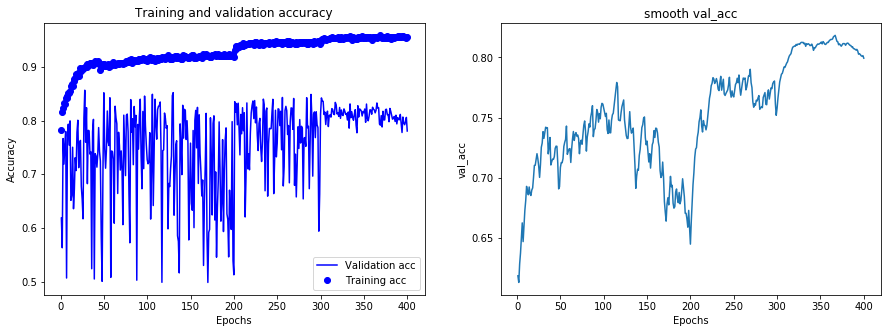

Highest val accuracy: x= 27, y= 0.8566536203522505


<Figure size 432x288 with 0 Axes>

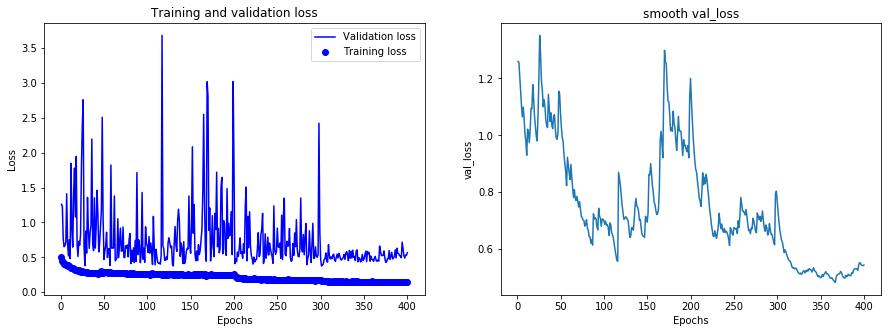

Lowest val loss: x= 300, y= 0.3747196895327353
36948.86123943329


In [12]:
plot_graphs(historyP4M_DenseNet_48_DROPOUT)
print(timeP4M_DenseNet_48_DROPOUT)

In [13]:
P4M_DenseNet_48_DROPOUT.evaluate_generator(test_generator,steps=len(test_generator)-1)

[0.5628383885157785, 0.772902397260274]

<Figure size 432x288 with 0 Axes>

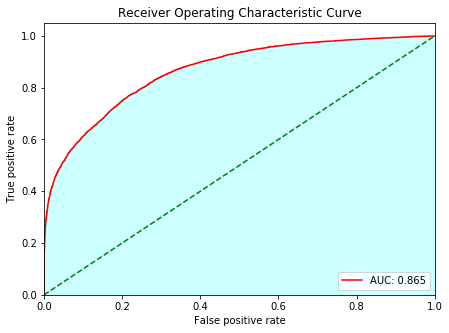

In [14]:
evaluate_auc(P4M_DenseNet_48_DROPOUT,test_generator)

In [16]:
P4M_DenseNet_48_DROPOUT.load_weights("model_saves/PCAM/PCAM_DENSE/P4M_DenseNet_48_DROPOUTBestWeights301epochs.hdf5")

In [17]:
P4M_DenseNet_48_DROPOUT.evaluate_generator(test_generator,steps=len(test_generator)-1)

[0.40384043318651425, 0.8340569960861057]

<Figure size 432x288 with 0 Axes>

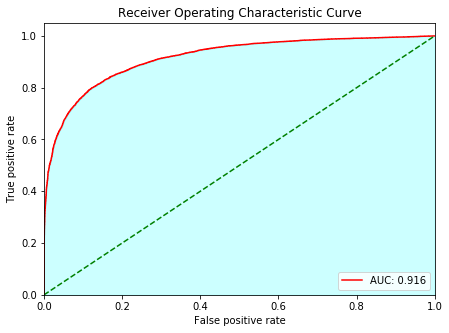

In [18]:
evaluate_auc(P4M_DenseNet_48_DROPOUT,test_generator)

# Models with growth rate 10 <a class="anchor" id="gr10"></a>
----------------------------------

In [4]:
initial_filters = 12
weight_decay = 1e-4 # Setting from the DenseNet paper
P4M_DenseNet_96 = build_and_compile_dense_model(initial_filters,growth_rate=12,dense_blocks=5,conv_layers=1,
                                           is_gconv=True,gconv_type="D4",padding="valid",dropout=0.2,img_size=96,
                                           opt="DenseSGD",weight_decay=weight_decay,output="sigmoid",labels=1,bc_model=False)

In [5]:
P4M_DenseNet_96.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 96, 96, 3)    0                                            
__________________________________________________________________________________________________
g_conv2d_1 (GConv2D)            (None, 94, 94, 96)   324         input_1[0][0]                    
__________________________________________________________________________________________________
g_batch_norm_1 (GBatchNorm)     (None, 94, 94, 96)   96          g_conv2d_1[0][0]                 
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 94, 94, 96)   0           g_batch_norm_1[0][0]             
__________________________________________________________________________________________________
g_conv2d_2

In [7]:
%%notify

totalepochs=300

historyP4M_DenseNet_96 = fit_model_to_directory_generator(P4M_DenseNet_96,train_datagen,tr_dir,validation_generator,
                                           callbacks=callbacks,steps=312,val_steps=len(validation_generator)-1,batch_size=64,epochs=totalepochs,verbose=1)
timeP4M_DenseNet_96 = np.sum(time_check.epoch_times)
P4M_DenseNet_96.save_weights("../model_saves/PCAM/PCam_Dense/P4M_DenseNet_96Final.h5")

Found 262144 images belonging to 2 classes.
Epoch 1/300

Epoch 00001: LearningRateScheduler setting learning rate to 0.10000000149011612.
312/312 [==============================] - 129s 415ms/step - loss: 0.5201 - acc: 0.7875 - val_loss: 1.9134 - val_acc: 0.4994
Epoch 2/300

Epoch 00002: LearningRateScheduler setting learning rate to 0.10000000149011612.
312/312 [==============================] - 125s 401ms/step - loss: 0.4759 - acc: 0.8093 - val_loss: 0.5737 - val_acc: 0.7441
Epoch 3/300

Epoch 00003: LearningRateScheduler setting learning rate to 0.10000000149011612.
312/312 [==============================] - 125s 402ms/step - loss: 0.4585 - acc: 0.8160 - val_loss: 0.9817 - val_acc: 0.5194
Epoch 4/300

Epoch 00004: LearningRateScheduler setting learning rate to 0.10000000149011612.
312/312 [==============================] - 126s 404ms/step - loss: 0.4423 - acc: 0.8242 - val_loss: 0.6378 - val_acc: 0.7197
Epoch 5/300

Epoch 00005: LearningRateScheduler setting learning rate to 0.10000

312/312 [==============================] - 128s 411ms/step - loss: 0.2745 - acc: 0.9065 - val_loss: 0.8184 - val_acc: 0.6696
Epoch 39/300

Epoch 00039: LearningRateScheduler setting learning rate to 0.10000000149011612.
312/312 [==============================] - 128s 410ms/step - loss: 0.2599 - acc: 0.9136 - val_loss: 0.6074 - val_acc: 0.7331
Epoch 40/300

Epoch 00040: LearningRateScheduler setting learning rate to 0.10000000149011612.
312/312 [==============================] - 128s 410ms/step - loss: 0.2854 - acc: 0.9029 - val_loss: 0.8362 - val_acc: 0.6307
Epoch 41/300

Epoch 00041: LearningRateScheduler setting learning rate to 0.10000000149011612.
312/312 [==============================] - 128s 410ms/step - loss: 0.2713 - acc: 0.9066 - val_loss: 0.6829 - val_acc: 0.8043
Epoch 42/300

Epoch 00042: LearningRateScheduler setting learning rate to 0.10000000149011612.
312/312 [==============================] - 128s 410ms/step - loss: 0.2776 - acc: 0.9056 - val_loss: 0.6086 - val_acc: 0.

312/312 [==============================] - 128s 410ms/step - loss: 0.2352 - acc: 0.9269 - val_loss: 1.1597 - val_acc: 0.6483
Epoch 113/300

Epoch 00113: LearningRateScheduler setting learning rate to 0.10000000149011612.
312/312 [==============================] - 128s 411ms/step - loss: 0.2296 - acc: 0.9310 - val_loss: 0.9528 - val_acc: 0.7101
Epoch 114/300

Epoch 00114: LearningRateScheduler setting learning rate to 0.10000000149011612.
312/312 [==============================] - 128s 411ms/step - loss: 0.2376 - acc: 0.9255 - val_loss: 1.8038 - val_acc: 0.5016
Epoch 115/300

Epoch 00115: LearningRateScheduler setting learning rate to 0.10000000149011612.
312/312 [==============================] - 128s 411ms/step - loss: 0.2324 - acc: 0.9293 - val_loss: 1.2848 - val_acc: 0.6461
Epoch 116/300

Epoch 00116: LearningRateScheduler setting learning rate to 0.10000000149011612.
312/312 [==============================] - 128s 411ms/step - loss: 0.2356 - acc: 0.9271 - val_loss: 0.5667 - val_acc

312/312 [==============================] - 125s 400ms/step - loss: 0.1545 - acc: 0.9570 - val_loss: 0.4620 - val_acc: 0.8346
Epoch 187/300

Epoch 00187: LearningRateScheduler setting learning rate to 0.009999999776482582.
312/312 [==============================] - 125s 400ms/step - loss: 0.1536 - acc: 0.9578 - val_loss: 0.5772 - val_acc: 0.8194
Epoch 188/300

Epoch 00188: LearningRateScheduler setting learning rate to 0.009999999776482582.
312/312 [==============================] - 125s 400ms/step - loss: 0.1538 - acc: 0.9574 - val_loss: 0.5124 - val_acc: 0.8388
Epoch 189/300

Epoch 00189: LearningRateScheduler setting learning rate to 0.009999999776482582.
312/312 [==============================] - 125s 400ms/step - loss: 0.1507 - acc: 0.9568 - val_loss: 0.4787 - val_acc: 0.8496
Epoch 190/300

Epoch 00190: LearningRateScheduler setting learning rate to 0.009999999776482582.
312/312 [==============================] - 125s 401ms/step - loss: 0.1611 - acc: 0.9543 - val_loss: 0.9487 - val

312/312 [==============================] - 125s 400ms/step - loss: 0.1459 - acc: 0.9592 - val_loss: 0.5232 - val_acc: 0.8174
Epoch 224/300

Epoch 00224: LearningRateScheduler setting learning rate to 0.009999999776482582.
312/312 [==============================] - 125s 400ms/step - loss: 0.1415 - acc: 0.9582 - val_loss: 0.7116 - val_acc: 0.7891
Epoch 225/300

Epoch 00225: LearningRateScheduler setting learning rate to 0.009999999776482582.
312/312 [==============================] - 125s 400ms/step - loss: 0.1459 - acc: 0.9576 - val_loss: 0.6320 - val_acc: 0.7773
Epoch 226/300

Epoch 00226: LearningRateScheduler setting learning rate to 0.0009999999776482583.
312/312 [==============================] - 125s 400ms/step - loss: 0.1386 - acc: 0.9605 - val_loss: 0.3312 - val_acc: 0.8787
Epoch 227/300

Epoch 00227: LearningRateScheduler setting learning rate to 0.0009999999310821295.
312/312 [==============================] - 125s 400ms/step - loss: 0.1304 - acc: 0.9641 - val_loss: 0.3368 - v

312/312 [==============================] - 127s 407ms/step - loss: 0.1241 - acc: 0.9683 - val_loss: 0.3564 - val_acc: 0.8778
Epoch 261/300

Epoch 00261: LearningRateScheduler setting learning rate to 0.0009999999310821295.
312/312 [==============================] - 127s 408ms/step - loss: 0.1206 - acc: 0.9680 - val_loss: 0.5183 - val_acc: 0.8446
Epoch 262/300

Epoch 00262: LearningRateScheduler setting learning rate to 0.0009999999310821295.
312/312 [==============================] - 127s 408ms/step - loss: 0.1250 - acc: 0.9669 - val_loss: 0.3982 - val_acc: 0.8607
Epoch 263/300

Epoch 00263: LearningRateScheduler setting learning rate to 0.0009999999310821295.
312/312 [==============================] - 128s 409ms/step - loss: 0.1179 - acc: 0.9681 - val_loss: 0.4095 - val_acc: 0.8579
Epoch 264/300

Epoch 00264: LearningRateScheduler setting learning rate to 0.0009999999310821295.
312/312 [==============================] - 127s 408ms/step - loss: 0.1237 - acc: 0.9676 - val_loss: 0.3487 -

312/312 [==============================] - 128s 412ms/step - loss: 0.1189 - acc: 0.9668 - val_loss: 0.4390 - val_acc: 0.8585
Epoch 298/300

Epoch 00298: LearningRateScheduler setting learning rate to 0.0009999999310821295.
312/312 [==============================] - 128s 412ms/step - loss: 0.1217 - acc: 0.9665 - val_loss: 0.4130 - val_acc: 0.8627
Epoch 299/300

Epoch 00299: LearningRateScheduler setting learning rate to 0.0009999999310821295.
312/312 [==============================] - 128s 412ms/step - loss: 0.1140 - acc: 0.9700 - val_loss: 0.4551 - val_acc: 0.8600
Epoch 300/300

Epoch 00300: LearningRateScheduler setting learning rate to 0.0009999999310821295.
312/312 [==============================] - 128s 412ms/step - loss: 0.1174 - acc: 0.9674 - val_loss: 0.4906 - val_acc: 0.8467


<IPython.core.display.Javascript object>

<Figure size 432x288 with 0 Axes>

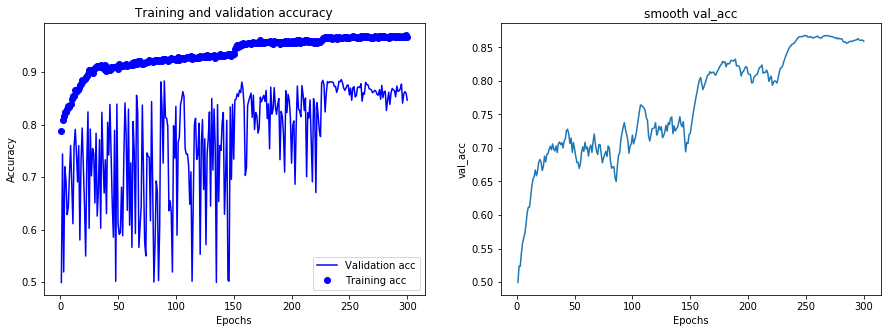

Highest val accuracy: x= 242, y= 0.8857326320939335


<Figure size 432x288 with 0 Axes>

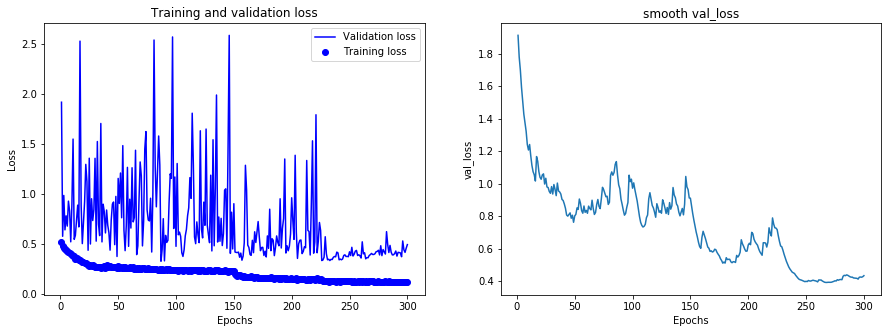

Lowest val loss: x= 86, y= 0.3244020450138532
38040.72065138817


In [8]:
plot_graphs(historyP4M_DenseNet_96)
print(timeP4M_DenseNet_96)

In [9]:
P4M_DenseNet_96.evaluate_generator(test_generator,steps=len(test_generator)-1)

[0.47456360790594215, 0.8386130136986302]

<Figure size 432x288 with 0 Axes>

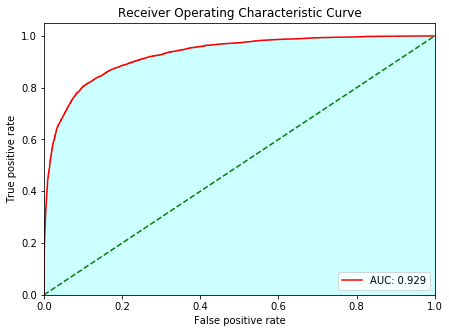

In [10]:
evaluate_auc(P4M_DenseNet_96,test_generator)

In [13]:
P4M_DenseNet_96.load_weights("../model_saves/PCAM/PCAM_Dense/P4M_DenseNet_96BestWeights87epochs.hdf5")

In [14]:
P4M_DenseNet_96.evaluate_generator(test_generator,steps=len(test_generator)-1)

[0.3987248772336079, 0.8509968199608611]

<Figure size 432x288 with 0 Axes>

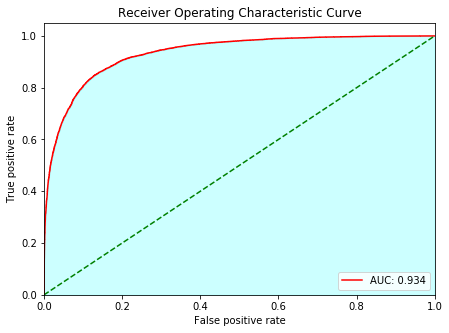

In [15]:
evaluate_auc(P4M_DenseNet_96,test_generator)

#### Rotational training version

In [5]:
callbacks = [time_check,
            keras.callbacks.ModelCheckpoint(
                filepath="../model_saves/PCAM/PCAM_Dense/weights.{epoch:02d}-{val_loss:.2f}.hdf5",
                monitor='val_loss',
                save_best_only=True),
             lr_mod
            ]

In [6]:
initial_filters = 12
weight_decay = 1e-4 # Setting from the DenseNet paper
P4M_DenseNet_96_ROTTRAIN = build_and_compile_dense_model(initial_filters,growth_rate=12,dense_blocks=5,conv_layers=1,
                                           is_gconv=True,gconv_type="D4",padding="valid",dropout=0.2,img_size=96,
                                           opt="Adam",weight_decay=weight_decay,output="sigmoid",labels=1,bc_model=False)

In [7]:
P4M_DenseNet_96_ROTTRAIN.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 96, 96, 3)    0                                            
__________________________________________________________________________________________________
g_conv2d_1 (GConv2D)            (None, 94, 94, 96)   324         input_1[0][0]                    
__________________________________________________________________________________________________
g_batch_norm_1 (GBatchNorm)     (None, 94, 94, 96)   96          g_conv2d_1[0][0]                 
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 94, 94, 96)   0           g_batch_norm_1[0][0]             
__________________________________________________________________________________________________
g_conv2d_2

In [8]:
%%notify

totalepochs=300

historyP4M_DenseNet_96_ROTTRAIN = fit_model_to_directory_generator(P4M_DenseNet_96_ROTTRAIN,train_datagen,tr_dir,validation_generator,
                                           callbacks=callbacks,steps=312,val_steps=len(validation_generator)-1,batch_size=64,epochs=totalepochs,verbose=1)
timeP4M_DenseNet_96_ROTTRAIN = np.sum(time_check.epoch_times)
P4M_DenseNet_96_ROTTRAIN.save_weights("../model_saves/PCAM/PCam_Dense/P4M_DenseNet_96_ROTTRAINFinal.h5")

Found 262144 images belonging to 2 classes.
Epoch 1/300
312/312 [==============================] - 133s 427ms/step - loss: 0.4912 - acc: 0.7937 - val_loss: 0.8345 - val_acc: 0.6071
Epoch 2/300
312/312 [==============================] - 128s 412ms/step - loss: 0.4469 - acc: 0.8202 - val_loss: 0.8422 - val_acc: 0.6235
Epoch 3/300
312/312 [==============================] - 128s 411ms/step - loss: 0.4319 - acc: 0.8269 - val_loss: 0.7751 - val_acc: 0.6277
Epoch 4/300
312/312 [==============================] - 129s 413ms/step - loss: 0.4128 - acc: 0.8336 - val_loss: 0.6000 - val_acc: 0.7742
Epoch 5/300
312/312 [==============================] - 129s 413ms/step - loss: 0.3997 - acc: 0.8407 - val_loss: 0.7566 - val_acc: 0.6622
Epoch 6/300
312/312 [==============================] - 128s 411ms/step - loss: 0.3764 - acc: 0.8512 - val_loss: 1.5188 - val_acc: 0.5473
Epoch 7/300
312/312 [==============================] - 127s 407ms/step - loss: 0.3499 - acc: 0.8651 - val_loss: 0.5941 - val_acc: 0.73

312/312 [==============================] - 124s 398ms/step - loss: 0.1313 - acc: 0.9628 - val_loss: 0.5187 - val_acc: 0.8293
Epoch 118/300
312/312 [==============================] - 124s 398ms/step - loss: 0.1341 - acc: 0.9598 - val_loss: 0.3345 - val_acc: 0.8812
Epoch 119/300
312/312 [==============================] - 124s 398ms/step - loss: 0.1264 - acc: 0.9646 - val_loss: 0.3932 - val_acc: 0.8528
Epoch 120/300
312/312 [==============================] - 124s 398ms/step - loss: 0.1301 - acc: 0.9619 - val_loss: 0.4535 - val_acc: 0.8559
Epoch 121/300
312/312 [==============================] - 124s 398ms/step - loss: 0.1297 - acc: 0.9635 - val_loss: 0.6131 - val_acc: 0.8118
Epoch 122/300
312/312 [==============================] - 124s 398ms/step - loss: 0.1294 - acc: 0.9640 - val_loss: 0.5552 - val_acc: 0.8493
Epoch 123/300
312/312 [==============================] - 124s 398ms/step - loss: 0.1227 - acc: 0.9657 - val_loss: 0.3344 - val_acc: 0.8789
Epoch 124/300
312/312 [==================

Epoch 232/300
312/312 [==============================] - 124s 398ms/step - loss: 0.1100 - acc: 0.9701 - val_loss: 0.5117 - val_acc: 0.8372
Learn rate updated from 3.906250185536919e-06 to: 1.9531250927684596e-06
Epoch 233/300
312/312 [==============================] - 124s 398ms/step - loss: 0.1088 - acc: 0.9687 - val_loss: 0.5050 - val_acc: 0.8381
Epoch 234/300
312/312 [==============================] - 124s 398ms/step - loss: 0.1115 - acc: 0.9693 - val_loss: 0.4987 - val_acc: 0.8380
Epoch 235/300
312/312 [==============================] - 124s 398ms/step - loss: 0.1049 - acc: 0.9710 - val_loss: 0.5125 - val_acc: 0.8356
Epoch 236/300
312/312 [==============================] - 124s 398ms/step - loss: 0.1088 - acc: 0.9691 - val_loss: 0.5057 - val_acc: 0.8377
Epoch 237/300
312/312 [==============================] - 125s 400ms/step - loss: 0.1042 - acc: 0.9711 - val_loss: 0.5126 - val_acc: 0.8380
Epoch 238/300
312/312 [==============================] - 125s 401ms/step - loss: 0.1089 - acc

<IPython.core.display.Javascript object>

<Figure size 432x288 with 0 Axes>

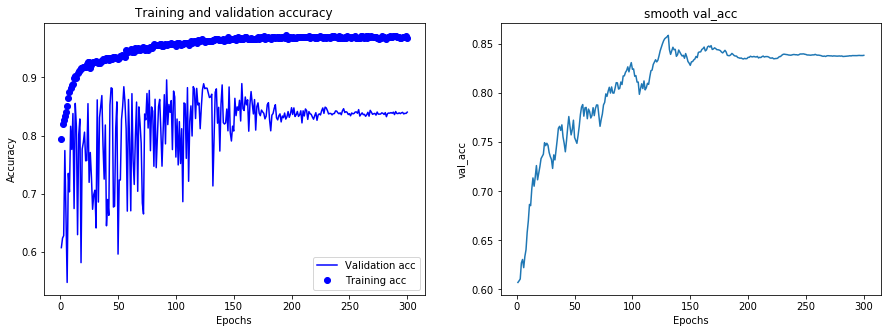

Highest val accuracy: x= 91, y= 0.8958231409001957


<Figure size 432x288 with 0 Axes>

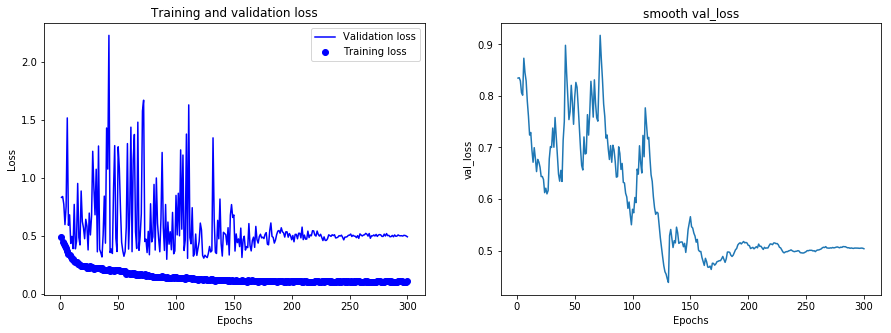

Lowest val loss: x= 91, y= 0.30114399264120073
37552.78101205826


In [9]:
plot_graphs(historyP4M_DenseNet_96_ROTTRAIN)
print(timeP4M_DenseNet_96_ROTTRAIN)

In [10]:
P4M_DenseNet_96_ROTTRAIN.evaluate_generator(test_generator,steps=len(test_generator)-1)

[0.6584762000057796, 0.8326504403131115]

<Figure size 432x288 with 0 Axes>

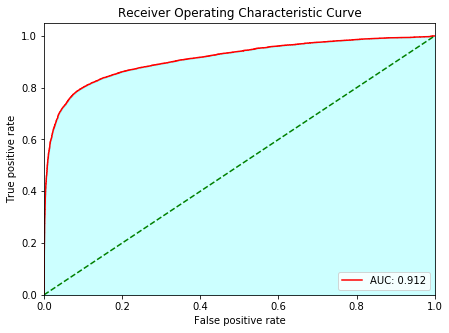

In [11]:
evaluate_auc(P4M_DenseNet_96_ROTTRAIN,test_generator)

In [12]:
P4M_DenseNet_96_ROTTRAIN.load_weights("../model_saves/PCAM/PCAM_Dense/P4M_DenseNet_96_ROTTRAINBestweights92epochs.hdf5")

In [13]:
P4M_DenseNet_96_ROTTRAIN.evaluate_generator(test_generator,steps=len(test_generator)-1)

[0.6183844355396095, 0.8330479452054794]

<Figure size 432x288 with 0 Axes>

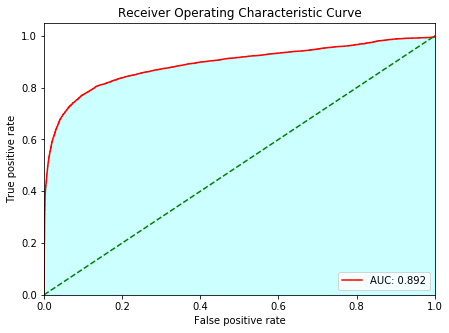

In [14]:
evaluate_auc(P4M_DenseNet_96_ROTTRAIN,test_generator)

#### Dropout version

In [7]:
initial_filters = 12
weight_decay = 1e-4 # Setting from the DenseNet paper
P4M_DenseNet_96_DROPOUT = build_and_compile_dense_model(initial_filters,growth_rate=12,dense_blocks=5,conv_layers=1,
                                           is_gconv=True,gconv_type="D4",padding="valid",dropout=0.5,img_size=96,
                                           opt="DenseSGD",weight_decay=weight_decay,output="sigmoid",labels=1,bc_model=False)

In [9]:
%%notify

totalepochs=300

historyP4M_DenseNet_96_DROPOUT = fit_model_to_directory_generator(P4M_DenseNet_96_DROPOUT,train_datagen,tr_dir,validation_generator,
                                           callbacks=callbacks,steps=312,val_steps=len(validation_generator)-1,batch_size=64,epochs=totalepochs,verbose=1)
timeP4M_DenseNet_96_DROPOUT = np.sum(time_check.epoch_times)
P4M_DenseNet_96_DROPOUT.save_weights("../model_saves/PCAM/PCam_Dense/P4M_DenseNet_96_DROPOUTFinal.h5")

Found 262144 images belonging to 2 classes.
Epoch 1/300

Epoch 00001: LearningRateScheduler setting learning rate to 0.10000000149011612.
312/312 [==============================] - 132s 425ms/step - loss: 0.5118 - acc: 0.7863 - val_loss: 1.2842 - val_acc: 0.5108
Epoch 2/300

Epoch 00002: LearningRateScheduler setting learning rate to 0.10000000149011612.
312/312 [==============================] - 128s 411ms/step - loss: 0.4561 - acc: 0.8179 - val_loss: 0.7939 - val_acc: 0.6690
Epoch 3/300

Epoch 00003: LearningRateScheduler setting learning rate to 0.10000000149011612.
312/312 [==============================] - 128s 412ms/step - loss: 0.4457 - acc: 0.8213 - val_loss: 0.7729 - val_acc: 0.6420
Epoch 4/300

Epoch 00004: LearningRateScheduler setting learning rate to 0.10000000149011612.
312/312 [==============================] - 128s 411ms/step - loss: 0.4134 - acc: 0.8377 - val_loss: 0.8317 - val_acc: 0.6251
Epoch 5/300

Epoch 00005: LearningRateScheduler setting learning rate to 0.10000

312/312 [==============================] - 126s 404ms/step - loss: 0.2650 - acc: 0.9130 - val_loss: 1.5941 - val_acc: 0.6121
Epoch 39/300

Epoch 00039: LearningRateScheduler setting learning rate to 0.10000000149011612.
312/312 [==============================] - 127s 407ms/step - loss: 0.2623 - acc: 0.9122 - val_loss: 2.4884 - val_acc: 0.6112
Epoch 40/300

Epoch 00040: LearningRateScheduler setting learning rate to 0.10000000149011612.
312/312 [==============================] - 128s 409ms/step - loss: 0.2612 - acc: 0.9152 - val_loss: 1.0145 - val_acc: 0.6047
Epoch 41/300

Epoch 00041: LearningRateScheduler setting learning rate to 0.10000000149011612.
312/312 [==============================] - 127s 407ms/step - loss: 0.2614 - acc: 0.9141 - val_loss: 3.1006 - val_acc: 0.5067
Epoch 42/300

Epoch 00042: LearningRateScheduler setting learning rate to 0.10000000149011612.
312/312 [==============================] - 126s 403ms/step - loss: 0.2593 - acc: 0.9156 - val_loss: 1.1915 - val_acc: 0.

312/312 [==============================] - 125s 401ms/step - loss: 0.2357 - acc: 0.9296 - val_loss: 1.0045 - val_acc: 0.7148
Epoch 113/300

Epoch 00113: LearningRateScheduler setting learning rate to 0.10000000149011612.
312/312 [==============================] - 125s 401ms/step - loss: 0.2361 - acc: 0.9270 - val_loss: 2.6709 - val_acc: 0.5585
Epoch 114/300

Epoch 00114: LearningRateScheduler setting learning rate to 0.10000000149011612.
312/312 [==============================] - 125s 400ms/step - loss: 0.2383 - acc: 0.9261 - val_loss: 0.9054 - val_acc: 0.7270
Epoch 115/300

Epoch 00115: LearningRateScheduler setting learning rate to 0.10000000149011612.
312/312 [==============================] - 124s 398ms/step - loss: 0.2419 - acc: 0.9247 - val_loss: 0.5484 - val_acc: 0.7875
Epoch 116/300

Epoch 00116: LearningRateScheduler setting learning rate to 0.10000000149011612.
312/312 [==============================] - 124s 398ms/step - loss: 0.2425 - acc: 0.9265 - val_loss: 1.1865 - val_acc

312/312 [==============================] - 127s 408ms/step - loss: 0.1588 - acc: 0.9545 - val_loss: 1.4906 - val_acc: 0.7048
Epoch 187/300

Epoch 00187: LearningRateScheduler setting learning rate to 0.009999999776482582.
312/312 [==============================] - 127s 408ms/step - loss: 0.1574 - acc: 0.9553 - val_loss: 0.9210 - val_acc: 0.7354
Epoch 188/300

Epoch 00188: LearningRateScheduler setting learning rate to 0.009999999776482582.
312/312 [==============================] - 127s 408ms/step - loss: 0.1619 - acc: 0.9534 - val_loss: 0.3726 - val_acc: 0.8611
Epoch 189/300

Epoch 00189: LearningRateScheduler setting learning rate to 0.009999999776482582.
312/312 [==============================] - 127s 408ms/step - loss: 0.1533 - acc: 0.9564 - val_loss: 1.0087 - val_acc: 0.7638
Epoch 190/300

Epoch 00190: LearningRateScheduler setting learning rate to 0.009999999776482582.
312/312 [==============================] - 127s 408ms/step - loss: 0.1603 - acc: 0.9548 - val_loss: 0.6711 - val

312/312 [==============================] - 125s 401ms/step - loss: 0.1557 - acc: 0.9538 - val_loss: 0.9050 - val_acc: 0.7047
Epoch 224/300

Epoch 00224: LearningRateScheduler setting learning rate to 0.009999999776482582.
312/312 [==============================] - 125s 400ms/step - loss: 0.1485 - acc: 0.9551 - val_loss: 1.4972 - val_acc: 0.6221
Epoch 225/300

Epoch 00225: LearningRateScheduler setting learning rate to 0.009999999776482582.
312/312 [==============================] - 125s 400ms/step - loss: 0.1539 - acc: 0.9547 - val_loss: 0.5908 - val_acc: 0.7917
Epoch 226/300

Epoch 00226: LearningRateScheduler setting learning rate to 0.0009999999776482583.
312/312 [==============================] - 125s 400ms/step - loss: 0.1451 - acc: 0.9577 - val_loss: 0.9811 - val_acc: 0.7370
Epoch 227/300

Epoch 00227: LearningRateScheduler setting learning rate to 0.0009999999310821295.
312/312 [==============================] - 125s 400ms/step - loss: 0.1384 - acc: 0.9607 - val_loss: 0.9432 - v

312/312 [==============================] - 124s 397ms/step - loss: 0.1351 - acc: 0.9609 - val_loss: 0.8581 - val_acc: 0.7586
Epoch 261/300

Epoch 00261: LearningRateScheduler setting learning rate to 0.0009999999310821295.
312/312 [==============================] - 124s 397ms/step - loss: 0.1357 - acc: 0.9603 - val_loss: 0.9309 - val_acc: 0.7484
Epoch 262/300

Epoch 00262: LearningRateScheduler setting learning rate to 0.0009999999310821295.
312/312 [==============================] - 124s 397ms/step - loss: 0.1278 - acc: 0.9643 - val_loss: 0.8864 - val_acc: 0.7664
Epoch 263/300

Epoch 00263: LearningRateScheduler setting learning rate to 0.0009999999310821295.
312/312 [==============================] - 124s 397ms/step - loss: 0.1294 - acc: 0.9643 - val_loss: 0.7297 - val_acc: 0.7855
Epoch 264/300

Epoch 00264: LearningRateScheduler setting learning rate to 0.0009999999310821295.
312/312 [==============================] - 124s 397ms/step - loss: 0.1373 - acc: 0.9616 - val_loss: 1.0936 -

312/312 [==============================] - 124s 397ms/step - loss: 0.1262 - acc: 0.9649 - val_loss: 0.9609 - val_acc: 0.7753
Epoch 298/300

Epoch 00298: LearningRateScheduler setting learning rate to 0.0009999999310821295.
312/312 [==============================] - 124s 397ms/step - loss: 0.1292 - acc: 0.9629 - val_loss: 0.8041 - val_acc: 0.7823
Epoch 299/300

Epoch 00299: LearningRateScheduler setting learning rate to 0.0009999999310821295.
312/312 [==============================] - 124s 398ms/step - loss: 0.1276 - acc: 0.9642 - val_loss: 0.7632 - val_acc: 0.7853
Epoch 300/300

Epoch 00300: LearningRateScheduler setting learning rate to 0.0009999999310821295.
312/312 [==============================] - 124s 398ms/step - loss: 0.1321 - acc: 0.9615 - val_loss: 0.8610 - val_acc: 0.7710


<IPython.core.display.Javascript object>

<Figure size 432x288 with 0 Axes>

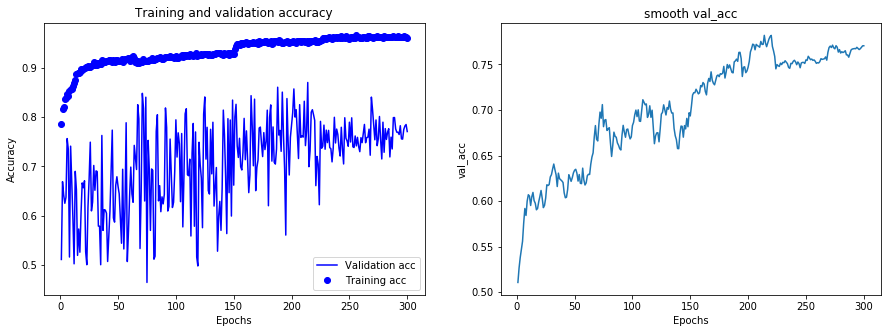

Highest val accuracy: x= 213, y= 0.8708109099804305


<Figure size 432x288 with 0 Axes>

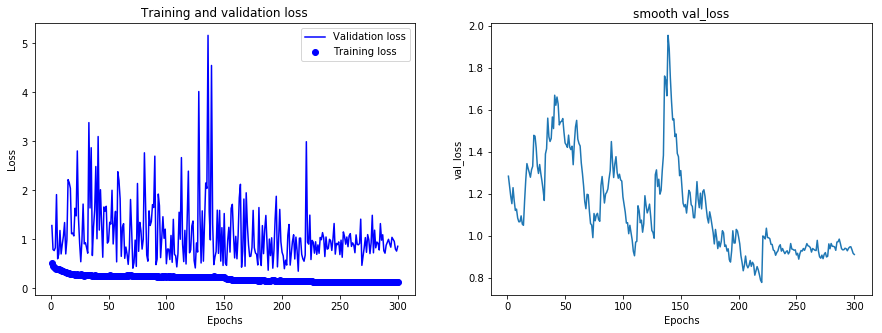

Lowest val loss: x= 213, y= 0.3527373556346576
37784.35062289238


In [10]:
plot_graphs(historyP4M_DenseNet_96_DROPOUT)
print(timeP4M_DenseNet_96_DROPOUT)

In [11]:
P4M_DenseNet_96_DROPOUT.evaluate_generator(test_generator,steps=len(test_generator)-1)

[0.6449563926971589, 0.7993823385518591]

<Figure size 432x288 with 0 Axes>

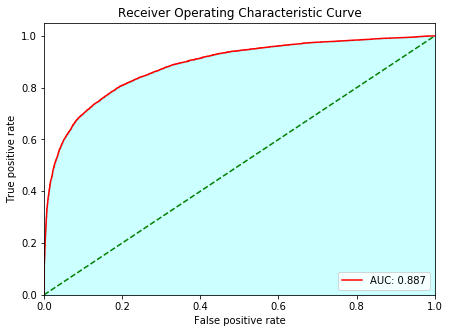

In [12]:
evaluate_auc(P4M_DenseNet_96_DROPOUT,test_generator)

In [13]:
P4M_DenseNet_96_DROPOUT.load_weights("../model_saves/PCAM/PCAM_Dense/P4M_DenseNet_96_DROPOUTBestWeights214epochs.hdf5")

In [14]:
P4M_DenseNet_96_DROPOUT.evaluate_generator(test_generator,steps=len(test_generator)-1)

[0.48409703006483107, 0.8354635518590998]

<Figure size 432x288 with 0 Axes>

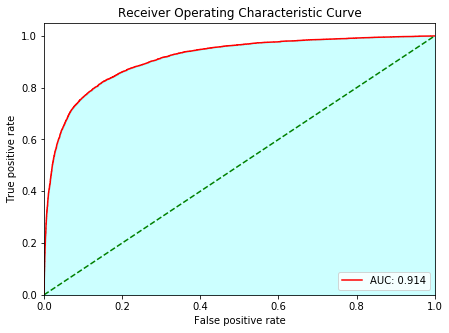

In [15]:
evaluate_auc(P4M_DenseNet_96_DROPOUT,test_generator)